### <center > ASSIGNMENT 1 - ADVANCED PROCESS MINING </center>

<center> Romayssa </center>
<center>Yasmin</center>
<center>Merve</center>

# Setup

In [110]:
import pandas as pd
import os
import copy
import math


# Log Conversion (pandas to log and vice versa)
from pm4py.objects.conversion.log import factory as log_conv
from pm4py.util import constants
# Alpha Miner
from pm4py.algo.discovery.alpha import factory as alpha_miner
# Heuristics Miner
from pm4py.algo.discovery.heuristics import factory as heuristics_miner
# Petri Net visualization
from pm4py.visualization.petrinet import factory as pn_vis_factory

from datetime import datetime

# Inductive Miner
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.algo.discovery.inductive import versions as IM_versions
# Fitness calculation algorithms
from pm4py.evaluation.replay_fitness import factory as replay_factory
# Precision Algorithms
from pm4py.evaluation.precision import factory as precision_factory
#Generalisation
from pm4py.evaluation.generalization import factory as generalization_factory
#simplicity
from pm4py.evaluation.simplicity import factory as simplicity_factory
# Sampling Logs
from pm4py.objects.log.util import sampling
# Classifier manipulation
from pm4py.objects.log.util import insert_classifier
# DFG
from pm4py.algo.discovery.dfg import factory as dfg_factory
from pm4py.algo.filtering.dfg import dfg_filtering
# DFG to Workflow-Net
from pm4py.objects.conversion.dfg import factory as dfg_mining_factory
# DFG Visualisation
from pm4py.visualization.dfg import factory as dfg_vis_factory
# Attribute Filtering
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.objects.log.util import basic_filter
from pm4py.objects.dfg.utils import dfg_utils
# Social Network Analysis
from pm4py.algo.enhancement.sna import factory as sna_factory
from pm4py.visualization.sna import factory as sna_vis_factory

from pm4py.objects.petri.check_soundness import check_petri_wfnet_and_soundness

from pm4py.visualization.sna.versions import pyvis
from pm4py.visualization.petrinet.util import performance_map, vis_trans_shortest_paths, alignments_decoration
from pm4py.statistics.passed_time.log import factory as log_passed_time
from pm4py.algo.filtering.log.attributes import attributes_filter as log_attributes_filter
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics

from pm4py.algo.enhancement.roles import factory as roles_factory
from pm4py.algo.filtering.log.end_activities import end_activities_filter
from sklearn import tree
from pm4py.visualization.decisiontree import factory as dt_vis_factory
from pm4py.objects.log.util import get_log_representation
from pm4py.objects.log.util import get_class_representation
from pm4py.objects.log.util.log import derive_and_lift_trace_attributes_from_event_attributes

In [2]:
# Path to the directory in which you should save you images (models and 
# other important analysis outputs where zooming in with an external program might be interesting)
path_save_base = os.path.abspath('./figures/')

In [3]:
# Mapping between dataset columns and PM4Py keys
# Many functions will require you to pass this as additional parameters
param_keys={constants.PARAMETER_CONSTANT_CASEID_KEY: 'Patient',
    constants.PARAMETER_CONSTANT_RESOURCE_KEY: 'Resource', 
    constants.PARAMETER_CONSTANT_ACTIVITY_KEY: 'Activity'}

# Preprocessing Functions

## DF Timestamps / Resource Formatting

In [4]:
def preprocess_df(df):
    """Preprocessing function that parses the timestamps and resource information.

    Converts timestamps to python datetime.
    Splits Resource information. PM4Py assumes comma separated resources.

    :df: DataFrame that should be processed
    :returns: Preprocessed DataFrame 

    """
    # Convert start timestamp
    df['start_timestamp'] = df['start_timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    # Convert end timestamp
    df['Timestamp'] = df['Timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    
    # Social Network Analysis wants comma separated resources
    df.loc[:, 'Resource'] = df.loc[:, 'Resource'].map(lambda s: s.replace('-', ',') if isinstance(s, str) else '')
    return df


# Load Data

In [5]:
# Data path
path_base_log = os.path.abspath('../')

In [6]:
# Read csv file into pandas DataFrame
df = pd.read_csv(os.path.join(path_base_log, 'log.csv'))
# Preprocess the DataFrame
df = preprocess_df(df)

In [7]:
log = log_conv.apply(df, parameters=param_keys)

#### Below, we create a helper function, which adds classifiers to logs imported from a CSV file. These classifiers are accessed by many algorithms used in this task.

In [8]:
def add_classifiers(log):
    log_copy = copy.deepcopy(log)
    
    for trace in log_copy:
        for event in trace:
            event['concept:name'] = event['Activity']
            event['org:resource'] = event['Resource']
            event['time:timestamp'] = event['Timestamp']
    
    return log_copy

In [9]:
log = add_classifiers(log)

# Q1. Inductive Miner

## a)
The following creates and visualizes a Petri-Net mined with the _inductive miner_ on the original log

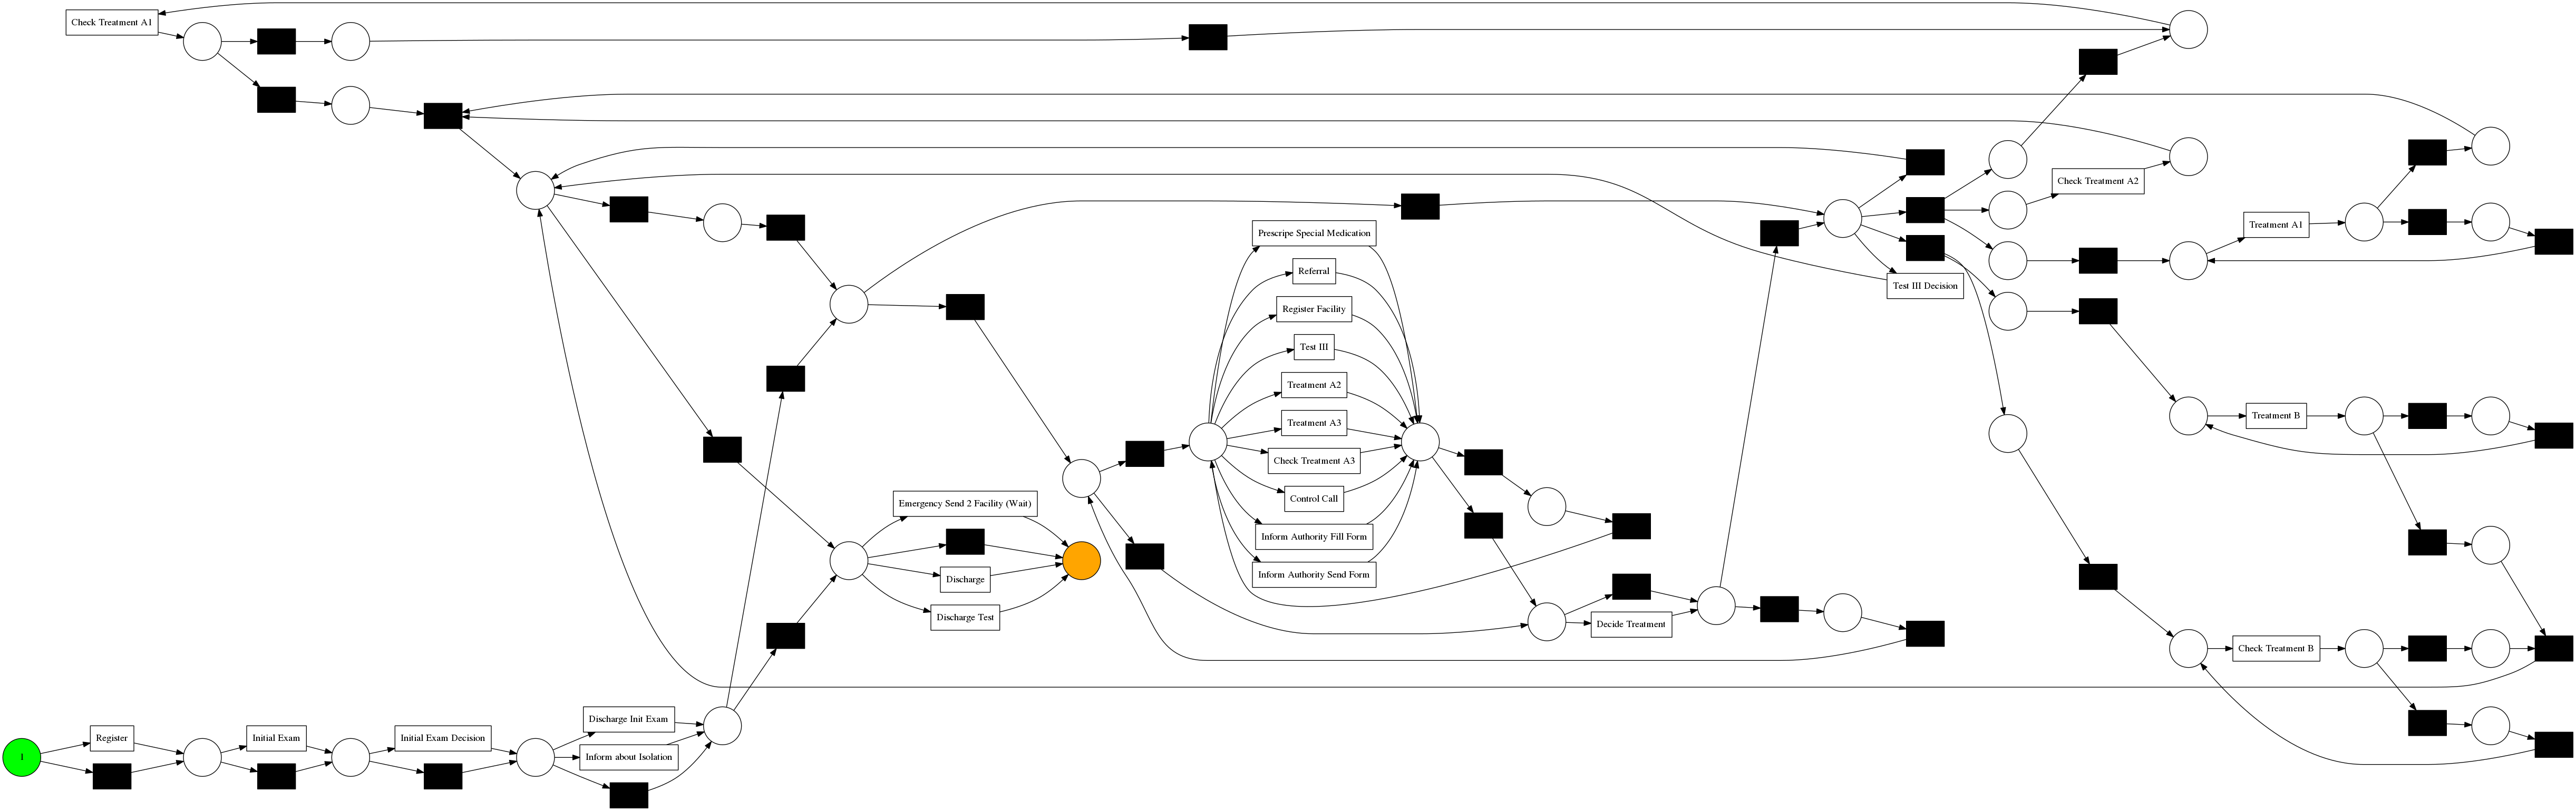

In [10]:
# Mine petri net with inductive miner
net, initial_marking, final_marking = inductive_miner.apply(log, parameters=param_keys)
# Visualize the petri net
parameters_figure ={"format":"svg"}
gviz = pn_vis_factory.apply(net, initial_marking, final_marking,parameters_figure)
pn_vis_factory.view(gviz)

In [11]:
file = "petri_question_a.svg"
dir_save=os.path.join(path_save_base,file)
pn_vis_factory.save(gviz,dir_save)

**Fitness calculation:**   
The Fitness of the resulting Petri-Net can be either calculated with _token-based replay_ or _alignment-based replay_. Both algorithms give similar results with _alignment-based replay_ being the faster one.

As can be seen in the results below, the _inductive miner_ results in almost perfect fitness, since it uses _silent transitions_ in order to provide a more flexible Petri-Net. This way almost all traces in the log can be replayed perfectly by the model.    

In [71]:
fitness_IMD  = replay_factory.apply(log, net, initial_marking, final_marking, param_keys)

In [72]:
print(fitness_IMD)

{'percFitTraces': 89.66666666666667, 'averageFitness': 0.9965523928326367}


**Precision calculation:**    
Consequently, the quality of the precision suffers immensely since the Petri-Net allows for too many different traces, that are not in the actual event log, and thus the precision decreases. 

In [73]:
precision_IMD = precision_factory.apply(log,net,initial_marking,final_marking, param_keys)

In [74]:
print(precision_IMD)

0.11288799510361114


**Generalization calculation:**   
Similar to the fitness, the generalization gives a high result. This is due to the fact that high fitness automatically influences the result of the generalization. 

In [75]:
generalization_IMD= generalization_factory.apply(log,net,initial_marking,final_marking, param_keys)

In [76]:
print(generalization_IMD)

0.9244865952056353


**Simplicity calculation:**

In [77]:
simplicity_IMD = simplicity_factory.apply(net)

In [78]:
print(simplicity_IMD)

0.6184971098265897


**Conclusion:**    
Although the fitness and generalization is almost perfect, the model itself still has some problems. Firstly, it allows for traces, that do not occur in the event log. Secondly, the order of the activities is not clear and thirdly, it allows for most activities being performed in duplicate, when in reality it should not happen for most of them. Therefore, the simplicity is also not satisfactory since the Petr-Net contains a giant loop consisting of 10 activities.

## b)      
In this task, we attempt to classify the _Control Call_ activity into two different activities. The _Control Call_ activity, that is performed before the _Test III_ activity, needs to be defined in a different context as the _Control Call_ activity that was performed after _Test III_. We accomplish this with the method below.     

In [12]:
def adjust_call(log):
    log_copy = copy.deepcopy(log)
    
    for trace in log_copy:
        after=False
        for event in trace:
            if event['Activity'] == 'Test III':
                after=True
            if after is True and event['Activity'] == 'Control Call':
                event['Activity'] = event['Activity'] + " Test"
    
    return add_classifiers(log_copy)  

In [13]:
new_log = adjust_call(log)

After we updated the log, we create a new Petri-Net with the _inductive miner_.

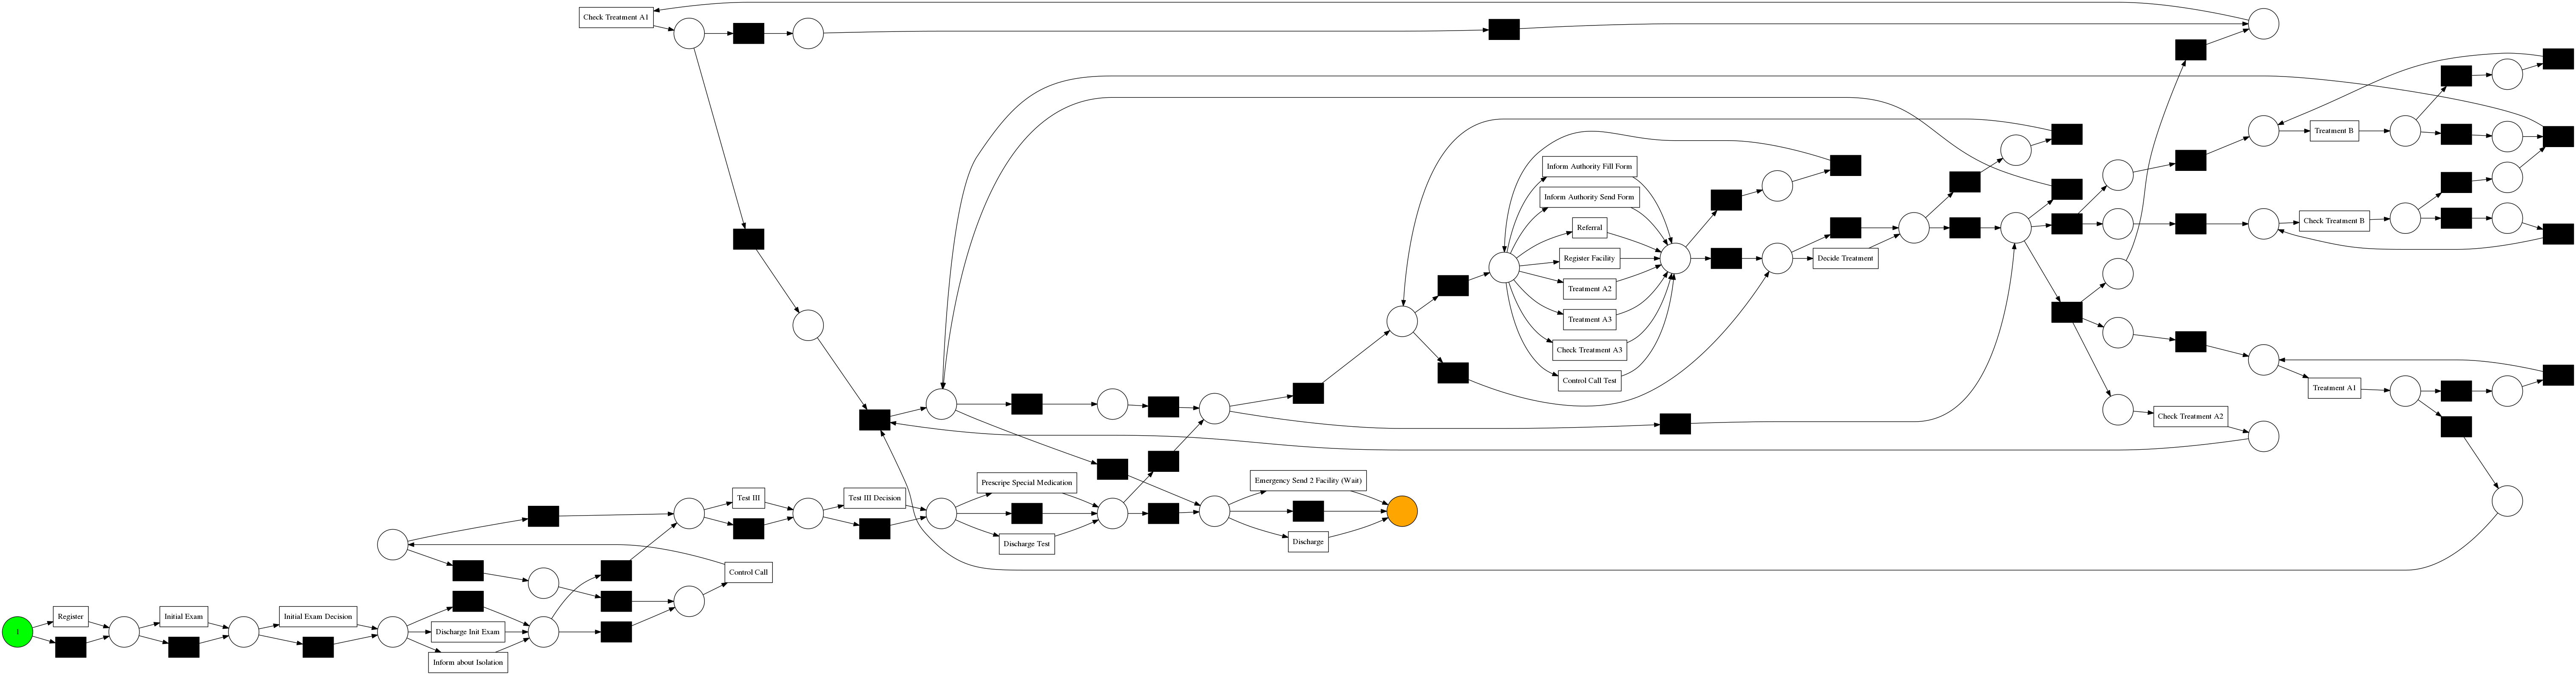

In [14]:
new_net, new_initial_marking, new_final_marking = inductive_miner.apply(new_log, parameters=param_keys)
gviz = pn_vis_factory.apply(new_net, new_initial_marking, new_final_marking,parameters_figure)
pn_vis_factory.view(gviz)

In [15]:
file = "petri_question_b.svg"
dir_save=os.path.join(path_save_base,file)
pn_vis_factory.save(gviz,dir_save)

**Fitness calculation:**

In [83]:
fitness_IMD  = replay_factory.apply(new_log, new_net, new_initial_marking, new_final_marking)

In [84]:
print(fitness_IMD)

{'percFitTraces': 89.66666666666667, 'averageFitness': 0.9965523928326367}


**Precision calculation:**

In [85]:
precision_IMD = precision_factory.apply(new_log,new_net, new_initial_marking, new_final_marking , param_keys)

In [86]:
print(precision_IMD)

0.10938277880824199


**Generalization calculation**:

In [87]:
generalization_IMD= generalization_factory.apply(new_log,new_net, new_initial_marking, new_final_marking , param_keys)

In [88]:
print(generalization_IMD)

0.9277469044047992


**Simplicity calculation**

In [89]:
simplicity_IMD = simplicity_factory.apply(new_net)

In [90]:
print(simplicity_IMD)

0.6373056994818652


**Conclusion:**    
The resulting process workflow makes significantly more sense. Now we can see that activities _Test III, Test Decision,_ and _Prescripe Special Medication_ occur before the workflow enters the loop. The initial Petri-Net modeled the _Test III_ and _Prescripe Special Medication_ as repeating activities, whereas in the new model it is not the case, and is thus modeled correctly.

## c)    
Here we attempt to reduce noise by utilizing the DFG module. We first create a DFG and then apply filtering with the `dfg_filtering` method, which removes traces containing activities below a given frequency threshold. 

In [16]:
dfg = dfg_factory.apply(new_log)
dfg_filtered = dfg_filtering.apply(dfg)

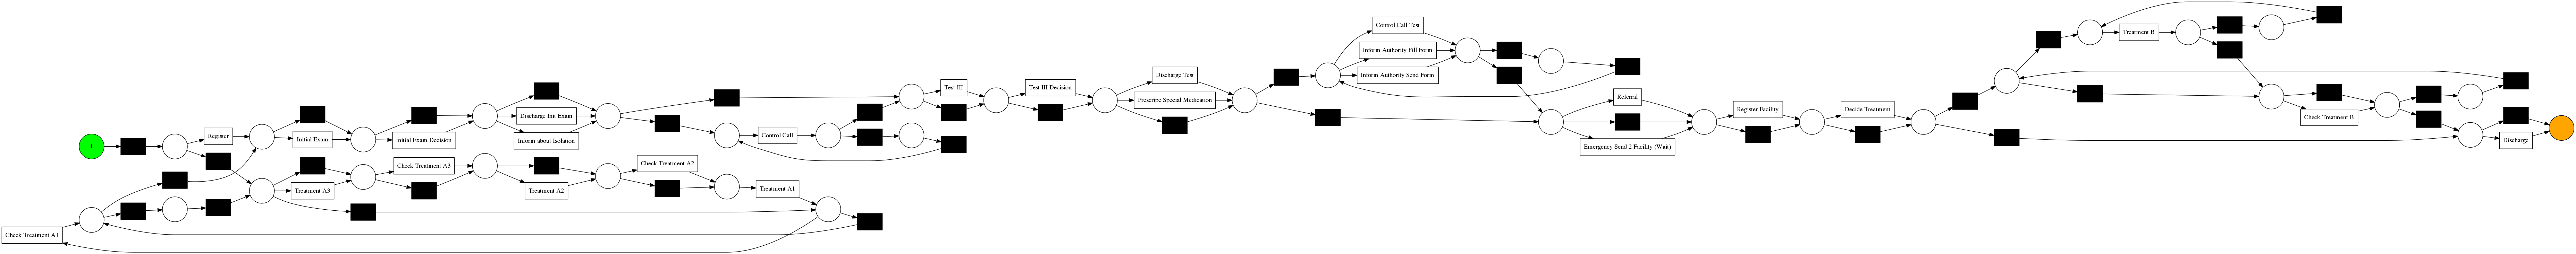

In [17]:
dfg_net, im, fm = IM_versions.dfg.dfg_based.apply_dfg(dfg_filtered, parameters=param_keys)
gviz = pn_vis_factory.apply(dfg_net, im, fm,parameters_figure)
pn_vis_factory.view(gviz)

In [18]:
file = "petri_question_c.svg"
dir_save=os.path.join(path_save_base,file)
pn_vis_factory.save(gviz,dir_save)

The resulting Petri-Net shows a clear outline of the workflow. Now we can observe, that _Control Call_ is happening in parallel to activities _Test III_ and after. Furthermore, we can also say that activities _Control Call Test, Inform Authority Fill Form_ and _Inform Authority Send Form_ do not occur in every trace, since they are modeled as choice. Another thing that we noticed is that activities _Check Treatment B_ and _Treatment B_ occur after _Decide Treatment_ , while this is not the case for treatments in _A_. 

**Fitness calculation:**

In [94]:
fitness_IMD  = replay_factory.apply(new_log,dfg_net, im, fm)

In [95]:
print(fitness_IMD)

{'percFitTraces': 86.8, 'averageFitness': 0.9742905720392385}


**Precision Calculation:**

In [96]:
precision_IMD= precision_factory.apply(new_log,dfg_net, im, fm  , param_keys)

In [97]:
print(precision_IMD)

0.16841569610697726


**Generalization calculation:**

In [98]:
generalization_IMD= generalization_factory.apply(new_log,dfg_net, im, fm  , param_keys)

In [99]:
print(generalization_IMD)

0.942845120563586


**Simplicity calculation:**

In [100]:
simplicity_IMD = simplicity_factory.apply(dfg_net)

In [101]:
print(simplicity_IMD)

0.6287425149700598


**Conclusion:**    
Although the workflow seems more precise, it still models noise since it now allows for more start activities, e.g. _Treatment A3_ or _Check Treatment A1_. As a consequence, the model only allows these activities activities to trigger at the beginning and not later on, which means that traces containing _Treatment A_ cannot be replayed.

## d)

Here we first create a DFG in order to investigate which activities need to be removed, such that the DFG results in a more precise workflow. We use the _frequency_ variant, in order to observe whether the frequency plays a role in the result.

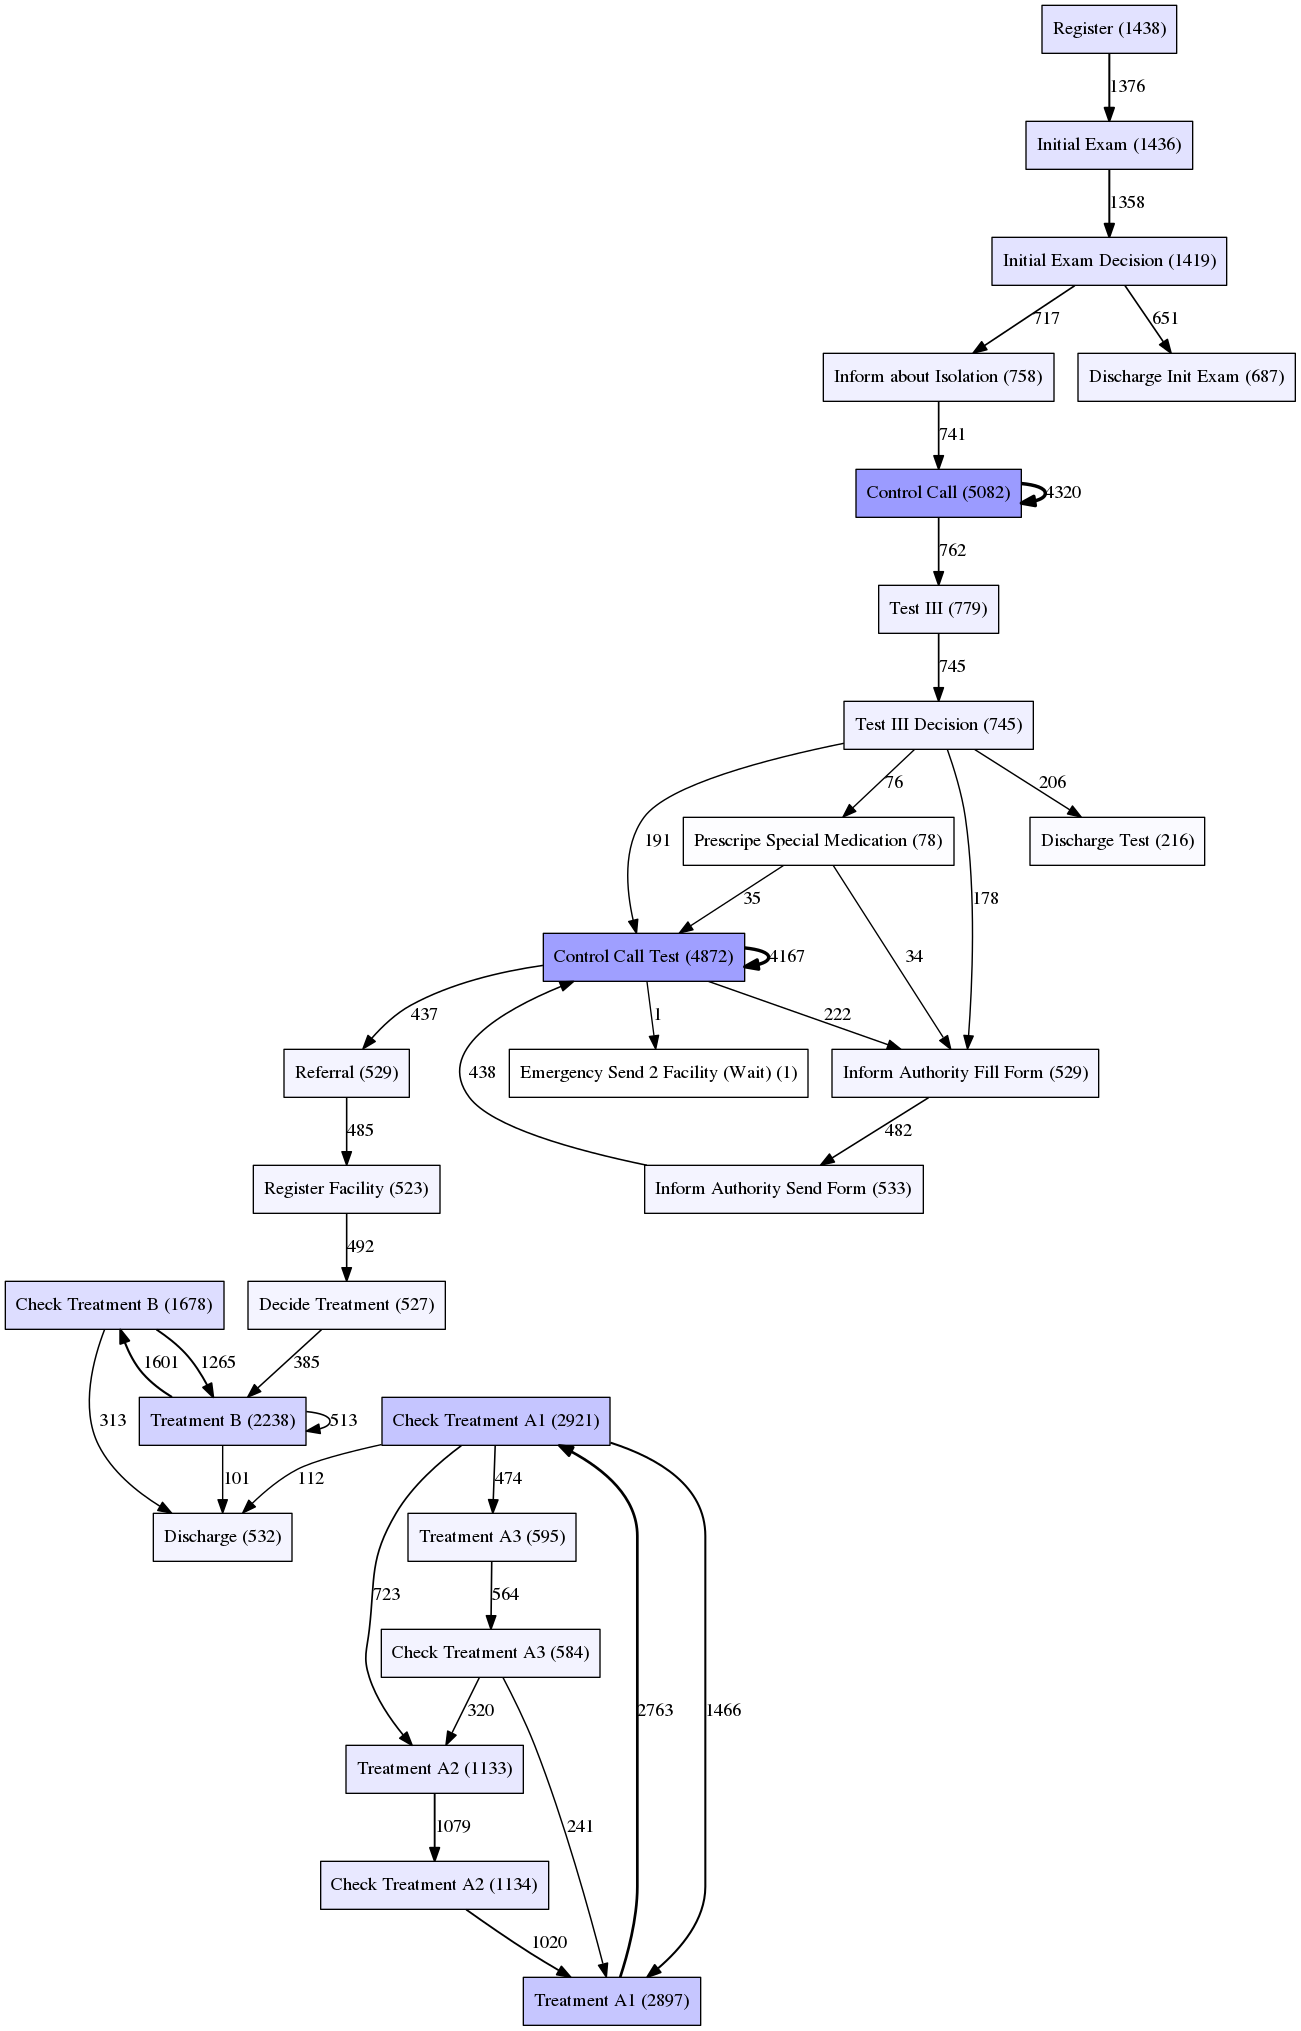

In [19]:
gviz = dfg_vis_factory.apply(dfg_filtered, log=new_log, variant="frequency")
dfg_vis_factory.view(gviz)

In [20]:
file = "dfg_question_d.svg"
dir_save=os.path.join(path_save_base,file)
pn_vis_factory.save(gviz,dir_save)

As can be seen in the resulting graph activity _Emergency Send 2 Facility (Wait)_ occurs only once and might cause noise. Furthermore, we know that the activity _Inform Authority Send Form_ should always be followed by activity _Inform Authority Fill Form_ , but this is not necessarily the case, since activity _Control Call Test_ occurs in parallel, thus causing noise. Our idea would be to 'merge' _Inform Authority Fill Form_ and _Inform Authority Send Form_ by simply removing the former.

In [21]:
activities = dfg_utils.get_activities_from_dfg(dfg_filtered)

activities.remove("Emergency Send 2 Facility (Wait)")
activities.remove("Inform Authority Fill Form")

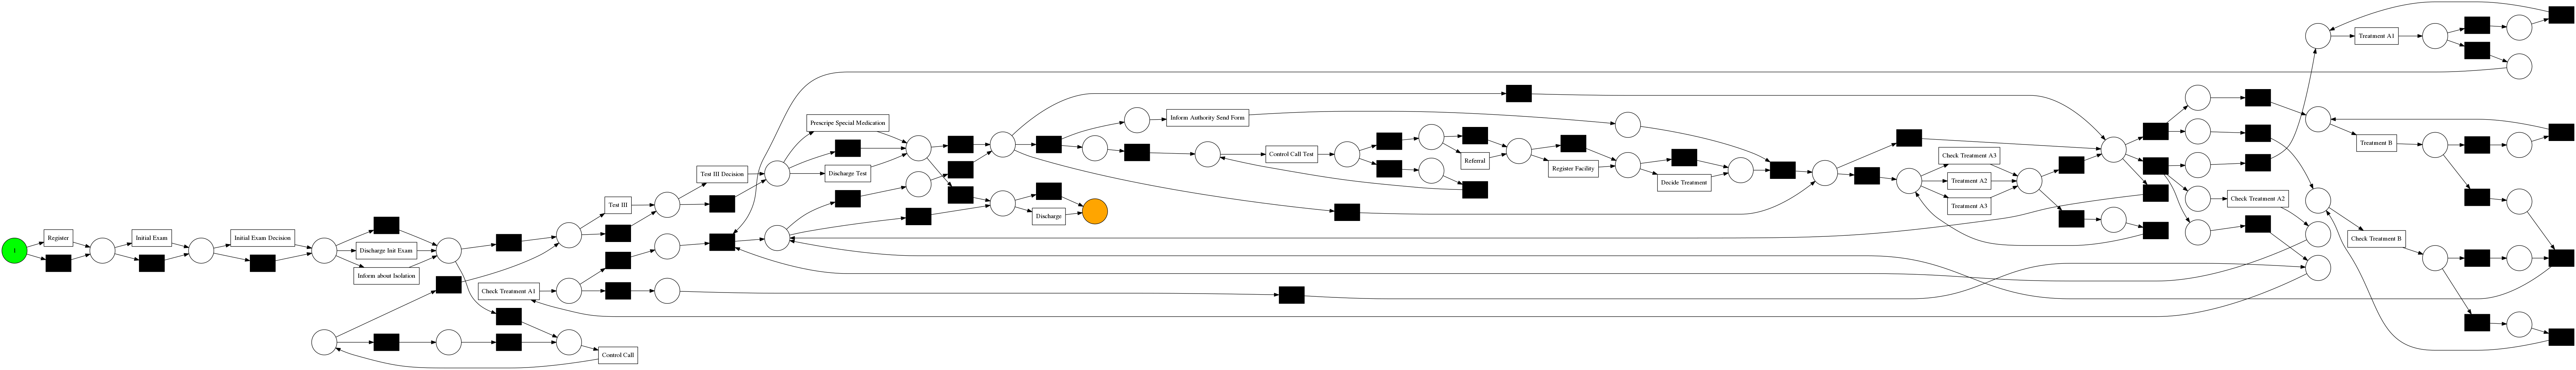

In [22]:
filter_log = basic_filter.filter_log_events_attr(new_log, activities)

new_net, new_initial_marking, new_final_marking = inductive_miner.apply(filter_log, parameters=param_keys)

gviz = pn_vis_factory.apply(new_net, new_initial_marking, new_final_marking,parameters_figure)
pn_vis_factory.view(gviz)

In [23]:
file = "petri_question_d.svg"
dir_save=os.path.join(path_save_base,file)
pn_vis_factory.save(gviz,dir_save)

After applying the inductive miner, we can see that _Control Call_ does not interfere with other activities anymore but can instead occur multiple times consecutively. In contrast, the _Control Call Test_ activity can occur multiple times in between _Inform Authority Send Form_ and all the other following activities. 

**Fitness calculation:**

In [107]:
fitness_IMD  = replay_factory.apply(filter_log,new_net, new_initial_marking, new_final_marking)

In [108]:
print(fitness_IMD)

{'percFitTraces': 85.13333333333334, 'averageFitness': 0.9925190261848598}


**Precision calculation:**

In [109]:
precision_IMD= precision_factory.apply(filter_log, new_net, new_initial_marking, new_final_marking)

In [110]:
print(precision_IMD)

0.1497671151855685


**Generalization calculation:**

In [112]:
print(generalization_IMD)

0.9515796777251676


In [30]:
generalization_IMD= generalization_factory.apply(filter_log, new_net, new_initial_marking, new_final_marking, param_keys)

In [31]:
print(generalization_IMD)

0.9515796777251676


**Simplicity calculation:**

In [113]:
simplicity_IMD = simplicity_factory.apply(new_net)

In [114]:
print(simplicity_IMD)

0.6683417085427136


**Conclusion:**     
The resulting Petri-Net shows a much clearer outline of the process. It consists of fewer loops and separates groups of activities, such as administrative and treatment related, much better. We can also easily observe which activities are followed and preceded by which activities.

### e) 

Here we apply a new filter to the log obtained in the previous subtask and only keep all traces containing the activitiy _Prescripe Special Medication_. The first thing that we observe is that patients who were prescript the special medication are never treated by _Treatment B_. Furthermore, we observe that _Control Call_ will most definitely occur before _Precripe Special Medication_ , and we can also say with confidence that _Test III_ will never be skipped. Unlike in the previous model (d), the _Control Call Test_ activity is not occurring in parallel anymore and that any of these activities: _Control Call Test, Inform Authority Send Form_ and _Referral_ will be eventually followed by _Register Facility_. And lastly, there is not a possibility of _Prescripe Special Medication_ being discharged immediately, only after being followed by _Check Treatment A1_ or _Treatment A1_.

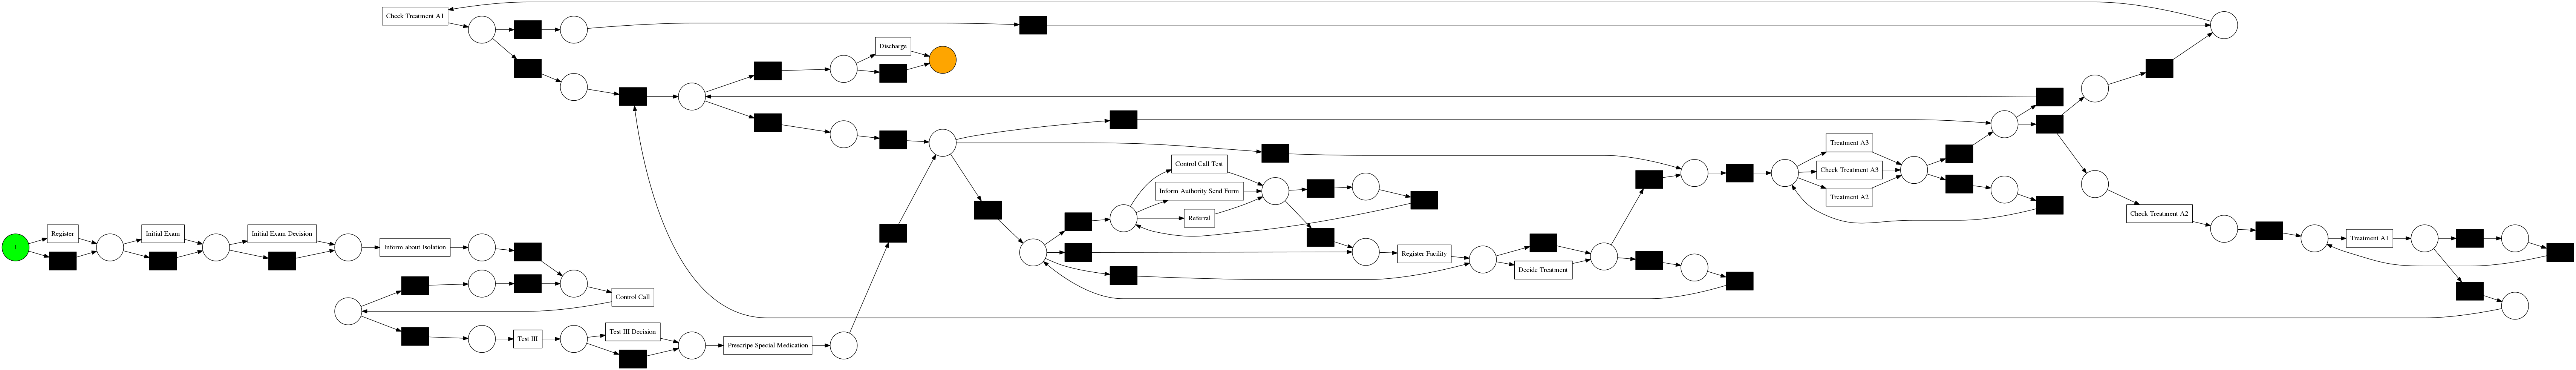

In [24]:
filter_log2 = attributes_filter.apply(filter_log, ["Prescripe Special Medication"], parameters={
                                                  constants.PARAMETER_CONSTANT_ATTRIBUTE_KEY: "concept:name", 
                                                  "positive": True})

new_net, new_initial_marking, new_final_marking = inductive_miner.apply(filter_log2, parameters=param_keys)
gviz = pn_vis_factory.apply(new_net, new_initial_marking, new_final_marking,parameters_figure)
pn_vis_factory.view(gviz)

In [26]:
file = "petri_question_e.svg"
dir_save=os.path.join(path_save_base,file)
pn_vis_factory.save(gviz,dir_save)

**Fitness calculation:**

In [119]:
fitness_IMD  = replay_factory.apply(new_log, new_net, new_initial_marking, new_final_marking)

In [120]:
print(fitness_IMD)

{'percFitTraces': 0.13333333333333333, 'averageFitness': 0.5987285947871253}


**Precision calculation:**

In [121]:
precision_IMD= precision_factory.apply(new_log, new_net, new_initial_marking, new_final_marking, param_keys)

In [122]:
print(precision_IMD)

0.5798221025448607


**Generalization calculation:**

In [123]:
generalization_IMD= generalization_factory.apply(new_log, new_net, new_initial_marking, new_final_marking, param_keys)

In [124]:
print(generalization_IMD)

0.921333466183336


**Simplicity calculation:**

In [125]:
simplicity_IMD = simplicity_factory.apply(new_net)

In [126]:
print(simplicity_IMD)

0.6764705882352942


## f)
## Alpha Miner
The Alpha miner models activities without any silent transitions, thus avoiding any noise. This might contribute to a high fitness AND high precision, however in terms of simplicity the model is very complex and loops are hard to visualize.

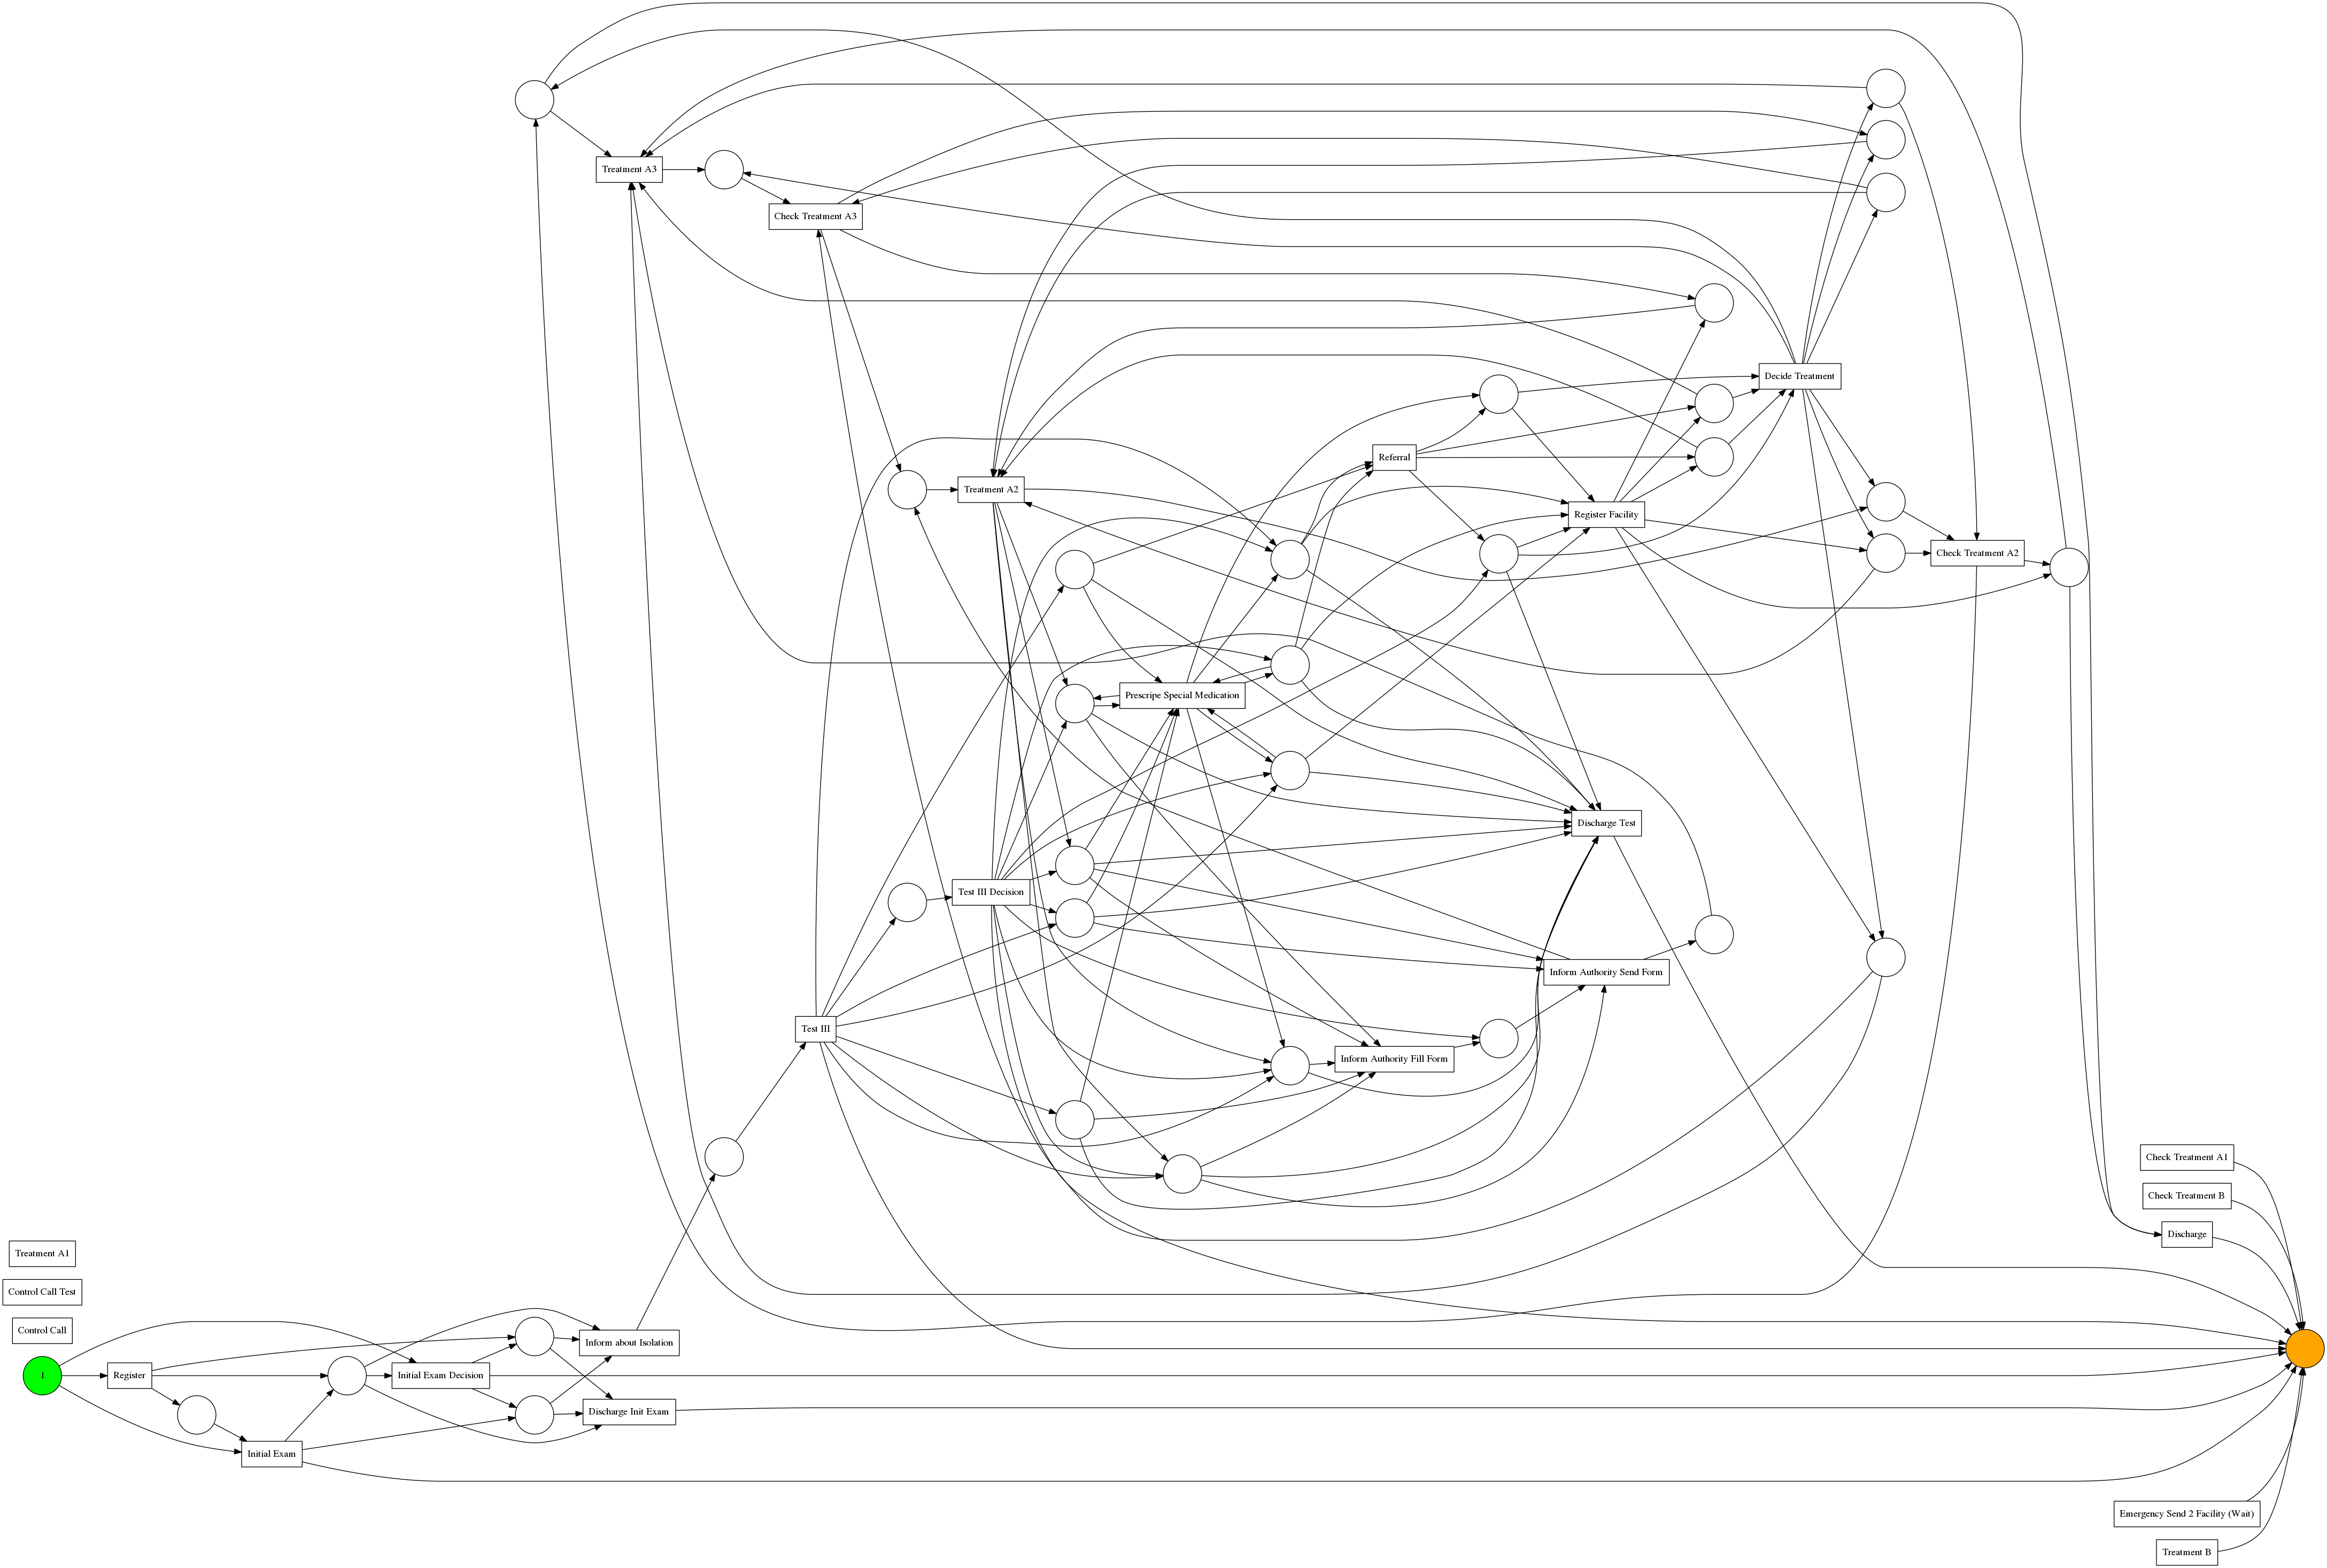

In [27]:
log_f = add_classifiers(new_log)
net, initial_marking, final_marking = alpha_miner.apply(log_f)
gviz = pn_vis_factory.apply(net, initial_marking, final_marking)
pn_vis_factory.view(gviz)

**Fitness calculation:**

In [128]:
fitness_alpha  = replay_factory.apply(log_f, net, initial_marking, final_marking)

In [129]:
print(fitness_alpha)

{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.6761938381684031, 'log_fitness': 0.5945891073758549}


**Precision calculation:**

In [130]:
precision_alpha = precision_factory.apply(log_f, net, initial_marking, final_marking)

In [131]:
print(precision_alpha)

0.0679778845282335


**Generalization calculation:**

In [132]:
generalization_alpha= generalization_factory.apply(log_f, net, initial_marking, final_marking)

In [133]:
print(generalization_alpha)

0.9261078126146702


**Simplicity calculation:**

In [134]:
simplicity_alpha = simplicity_factory.apply(net)

In [135]:
print(simplicity_alpha)

0.26180257510729615


**Soundness:**

In [28]:
is_sound = check_petri_wfnet_and_soundness(net)
print("Sound?", is_sound)

Sound? False


## Heuristics Miner

This particular discovery algorithm takes frequencies into account, and therefore can filter out noisy or infrequent behavior. Furthermore it's able to detect short loops and allows for skipping single activities.

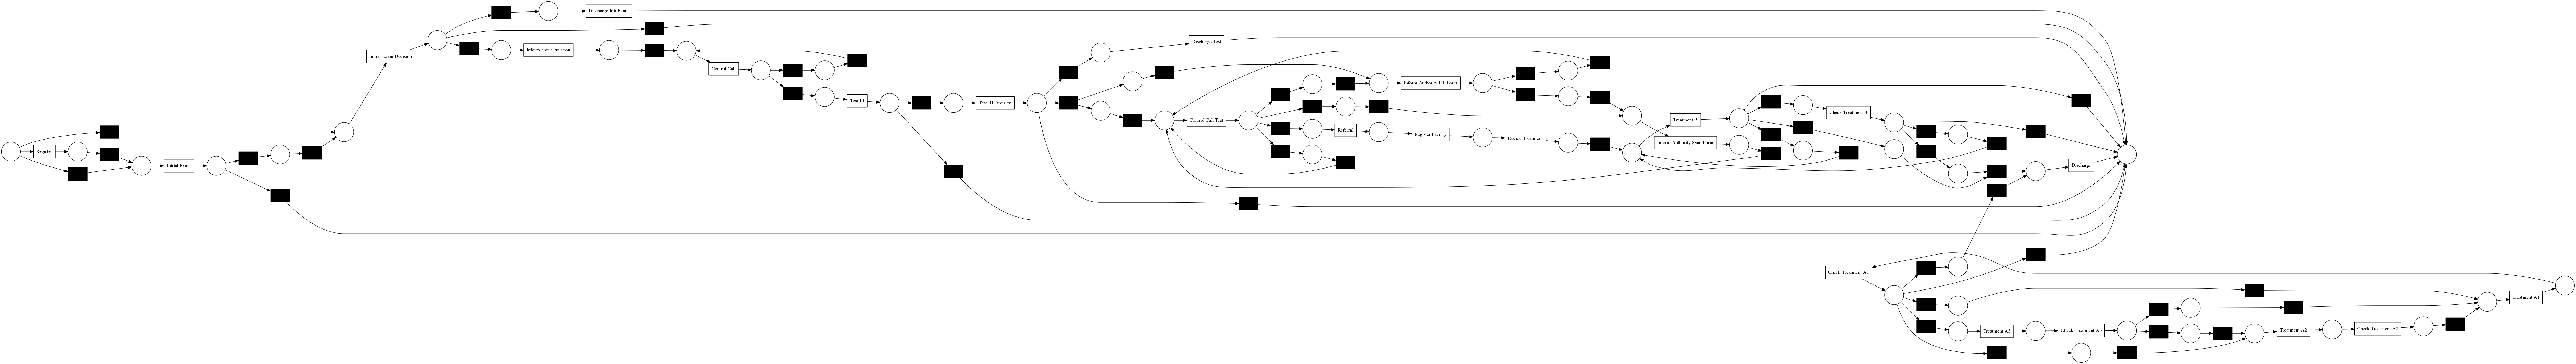

In [29]:
net, im, fm = heuristics_miner.apply(log_f, parameters={"dependency_thresh": 0.99})
gviz = pn_vis_factory.apply(net, initial_marking, final_marking,parameters_figure)
pn_vis_factory.view(gviz)

In [30]:
file = "petri_question_f.svg"
dir_save=os.path.join(path_save_base,file)
pn_vis_factory.save(gviz,dir_save)

**Fitness calculation:**    
~0.88

In [ ]:
fitness_HM  = replay_factory.apply(log_f, net, im, fm)

In [ ]:
print(fitness_HM)

**Precision calculation:**    
~0.569

In [ ]:
precision_HM = precision_factory.apply(log_f,net,im,fm)

In [ ]:
print(precision_HM)

**Generalization calculation:**    
~0.816

In [ ]:
generalization_HM= generalization_factory.apply(log_f, net, initial_marking, final_marking)

In [ ]:
print(generalization_HM)

**Simplicity calculation:**    
~0.751

In [ ]:
simplicity_HM = simplicity_factory.apply(net)

In [ ]:
print(simplicity_HM)

**Soundness:**

In [31]:
is_sound = check_petri_wfnet_and_soundness(net)
print("Sound?", is_sound)

Sound? False


# Q2. Social Network Analysis    


## a) Handover-of-Work Social Network

There exists an organizational structure divided into departments where people ( represented as communities in the network) within the department handover work to each other while only few people interact with other people not in the same department thus the structure obtained could be summarized as coummunties. 

We can also conclude that “Heli” does not handover work to any other individual, but was only handed over work. After investigating the log we can confirm that she is responsible for the activity _Emergency Send 2 Facility (Wait)_ which only occured once in the event log. 

We can also conclude that “Alina” is the person who recieves and hands over most of the work, which imples that she might be performing an activity involving many other individulas during the process. In contrast, _InspectorInis_ hands over work to few other people that are located in different departments. After further investigation we can confirm that _InspectorInis_ is responsible for _Control Call_ which is performed often mutliple times consecutively, hence InspectorInis hans over work to herself frequently.


In [32]:
wt_values = sna_factory.apply(new_log,parameters={'METRIC_NORMALIZATION':"metric_normalization",'ACTIVITY_KEY':constants.PARAMETER_CONSTANT_ACTIVITY_KEY,'RESOURCE_KEY':constants.PARAMETER_CONSTANT_RESOURCE_KEY} ,variant="handover")
gviz_wt=pyvis.apply(wt_values)
file = "handover_of_work.htm"
dir_save=os.path.join(path_save_base,file)
pyvis.save(gviz_wt,dir_save,parameters="html")

## b) Subcontracting Social Network

There are few edges in this network, implying that the phenomena of subcontracting work is not that frequent. 
Regarding the other subnetworks there is in each sub-network a person who frequently executes an activity in the middle between 2 other activities executed by the same person, this might imply that this person is responsible for a decisive action before the other resources can further their work. For instance "Celina" and "Caddy" perform the activity “decide treatment” then, the other individuals can proceed their tasks in the process for example applying treatment or checking on the treatment effect.

In [33]:
wt_values = sna_factory.apply(new_log,variant="subcontracting",parameters={'METRIC_NORMALIZATION':"metric_normalization",'ACTIVITY_KEY':constants.PARAMETER_CONSTANT_ACTIVITY_KEY,'RESOURCE_KEY':constants.PARAMETER_CONSTANT_RESOURCE_KEY})
gviz_wt=pyvis.apply(wt_values)
file = "subcontracting.htm"
dir_save=os.path.join(path_save_base,file)
pyvis.save(gviz_wt,dir_save,parameters="html")

## c) Working-Together Social Network


From the image bellow we can conclude that there 4 networks. Moreover, there is one central sub-network that is consists of: Anna, Amalia, Amelie, Alexander, Adrian, Ava, Inspectorlins and Alina. 
This particular sub-network in question is connected to all the other, meaning that these people are involved in all cases.

However, the remaining 3 sub-networks are composed of indivdulas that are also intraconnected, but each sub-network is interconnected to only the central sub-network mentioned above. Thsis means that each of the aforementioned 3 sub-networks do not work with each other.

This suggests that there are departments that are required only for specific tasks, as an example medication, where a healthy patient won’t be prescribed medication. For example inspectrois.


In [34]:
wt_values = sna_factory.apply(new_log,variant="working_together",parameters={'METRIC_NORMALIZATION':"metric_normalization",'ACTIVITY_KEY':constants.PARAMETER_CONSTANT_ACTIVITY_KEY,'RESOURCE_KEY':constants.PARAMETER_CONSTANT_RESOURCE_KEY})
gviz_wt=pyvis.apply(wt_values)
file = "working_together.htm"
dir_save=os.path.join(path_save_base,file)
pyvis.save(gviz_wt,dir_save,parameters="html")

## d) Joint-Activities Social Network

There exists 06 sub-networks where they all have high weights connections. 
But their structure differ a little bit: 

- 01 sub-graph has only two nodes: "Adrian" & "Amelie": looking at the log they both perform exclusively "Referral" & "Prescribe special medication".

- 01 sub graph has only for nodes: "Anna", "Amalia","Ava" & "Alina": looking in the log they all perform exclusively "inform about isolation", "inform activity fill form", "inform activity send form", "initial exam" & "test III".

- 01 sub graph with 10 nodes (10 poeple doing same activities) representing in the image bellow. (In the log there are activities that are performed by more than one ressource in the same instance at the same time, example from the log: Adrian and Amalia performed “Initial Exam decision” on “patient 05”).

-	01 sub-graph with arround 17 nodes, conecting 17 people. 

-	02 huge sub-graph connecting a lot of ressources together. This implies that there is a huge number of ressources doing the same activities.



In [35]:
ja_values = sna_factory.apply(new_log, variant="jointactivities",parameters={'METRIC_NORMALIZATION':"metric_normalization",'ACTIVITY_KEY':constants.PARAMETER_CONSTANT_ACTIVITY_KEY,'RESOURCE_KEY':constants.PARAMETER_CONSTANT_RESOURCE_KEY})

gviz_ja=pyvis.apply(ja_values)
file = "joint_activites.htm"
dir_save=os.path.join(path_save_base,file)
pyvis.save(gviz_ja,dir_save,parameters="html")

## Identifying Facilities

Now that we were able to get a deeper look into the organizational and behavioral structure of the process, we can derive facilities. We will start by discovering groups of resources, who perform similar activities and then try to derive activities that are corresponding to said resource. The Handover and Joint-Activities networks already provide a good starting point. The former shows which resources are working together and the latter shows which resources perform the same or similar activities. 


### 1. Identifying groups
We first use the _roles__factory_ API to fetch a list of activities that are mapped to resources including its occurrency frequency. Then we apply the result to the function _map__roles__to__groups_ in which we split resource pairs, remove the frequency and simply map the resources to the corresponding activity. The results are
formatted as follows: __[ ['My Activity'], ['resource 1', 'resource 2', ...] ]__.

In [38]:
roles = roles_factory.apply(new_log)

In [39]:
def map_roles_to_groups(roles):
    mapping = []
    
    for role in roles:
        _list = list()
        for resources in role[1]:
            if ',' in resources:
                lst = resources.split(',')
                _list.extend(lst)
            else:
                _list.append(resources)
        
        mapping.append([role[0], list(set(_list)) ])
            
    return mapping

In [40]:
roles = roles_factory.apply(new_log)
groups = map_roles_to_groups(roles)

Now, we aggregate all existing resources into a set.

In [41]:
all_resources = set()
for group in groups:
    all_resources.update(set(group[1]))

Below, we create groups that we observed from the communities in the Handover-Network:

In [42]:
group1 = ['Amalia', 'Ava', 'Anna', 'Alina']
group2 = ['Amelie', 'Adrian']

In [43]:
group3 = ['Benedikt', 'Bianca', 'Birgit', 'Babatunde', 'Barbara', 'Ben', 'Benjamin', 'Babelisk', 'Bruno', 'Babaoia', 'Babet', 'Bernhard', 'Brigitte', 'Bettina', 'Baal', 'Bella', 'Bente', 'Babak']
group4 = ['Christian', 'Chiara', 'Cadan', 'Carla', 'Cedrik', 'Charlotte', 'Cabdulaahi', 'Celine', 'Clara', 'Christina', 'Claudia', 'Cornelia', 'Celina', 'Cadel', 'Caddy', 'Cataleya', 'Cade', 'Carlotta']
group5 = ['Daban', 'Dace', 'Diana', 'David', 'Dacia', 'Daan', 'Denise', 'Dominik', 'Dana', 'Daniela', 'Daau', 'Devin', 'Dilara', 'Dennis', 'Daniel', 'Donika', 'Damian']

We compare the groups above to the resources in the Joint-Activity Network and notice that not all resources from the Handover are present, therefore the remaining resources are fetched and printed below.

In [44]:
ungrouped_resources = all_resources - set(group1).union(set(group2)).union(set(group3)).union(set(group4)).union(set(group5))
print(ungrouped_resources)

{'Alexander', 'InspectorInis', 'Heli'}


Each of these unassigned resources, can each be assigned to a separate group conisting only of themselves.

In [45]:
group6 = ['Heli']
group7 = ['InspectorInis']
group8 = ['Alexander']

### 2. Assigning groups to activities

Now we try to map and cluster these groups according to the activities they perform. In order to achieve this we query the pm4py api for roles. 
We implement the _jaccard similarity_ function, in order to compare which groups tend to be similar.

In [46]:
def jaccard_similarity(_list1, _list2):
    set1 = set(_list1)
    set2 = set(_list2)
    return len(set1.intersection(set2)) / len(set1.union(set2))

The output below shows which groups have performed which activities:

In [47]:
for group in groups:
    sim1 = jaccard_similarity(group[1], group1) 
    sim2 = jaccard_similarity(group[1], group2) 
    sim3 = jaccard_similarity(group[1], group3) 
    sim4 = jaccard_similarity(group[1], group4) 
    sim5 = jaccard_similarity(group[1], group5) 
    sim6 = jaccard_similarity(group[1], group6) 
    sim7 = jaccard_similarity(group[1], group7) 
    sim8 = jaccard_similarity(group[1], group8) 
    print('\033[1m', group[0], '\033[0m', '\n')
    print("G1", sim1, '\t', "G2", sim2, '\t', "G3", sim3, '\t', "G4", sim4, '\t', "G5", sim5, '\t', "G6", sim6, '\t', "G7", sim7, '\t', "G8", sim8 )
    print("______________________________________________________________________________________________________________\n")

 ['Check Treatment A1']  

G1 0.0 	 G2 0.0 	 G3 0.33962264150943394 	 G4 0.33962264150943394 	 G5 0.32075471698113206 	 G6 0.0 	 G7 0.0 	 G8 0.0
______________________________________________________________________________________________________________

 ['Check Treatment A2']  

G1 0.0 	 G2 0.0 	 G3 0.33962264150943394 	 G4 0.33962264150943394 	 G5 0.32075471698113206 	 G6 0.0 	 G7 0.0 	 G8 0.0
______________________________________________________________________________________________________________

 ['Check Treatment A3']  

G1 0.0 	 G2 0.0 	 G3 0.33962264150943394 	 G4 0.33962264150943394 	 G5 0.32075471698113206 	 G6 0.0 	 G7 0.0 	 G8 0.0
______________________________________________________________________________________________________________

 ['Check Treatment B']  

G1 0.0 	 G2 0.0 	 G3 0.33962264150943394 	 G4 0.33962264150943394 	 G5 0.32075471698113206 	 G6 0.0 	 G7 0.0 	 G8 0.0
_____________________________________________________________________________________

**Conclusion:**

The results show that groups 3,4 and 5 perform the same activities, but never handover work to each other outside of their own group. This indicates that each of these groups are facilities performing the same activities, but probably in different locations.

# Q3. Performance Analysis
## a) 

We did here a petri net with frequency variant (derived from the filtred DFG petri net)

In [48]:
dfg_net, im, fm = IM_versions.dfg.dfg_based.apply_dfg(dfg_filtered, parameters=param_keys)

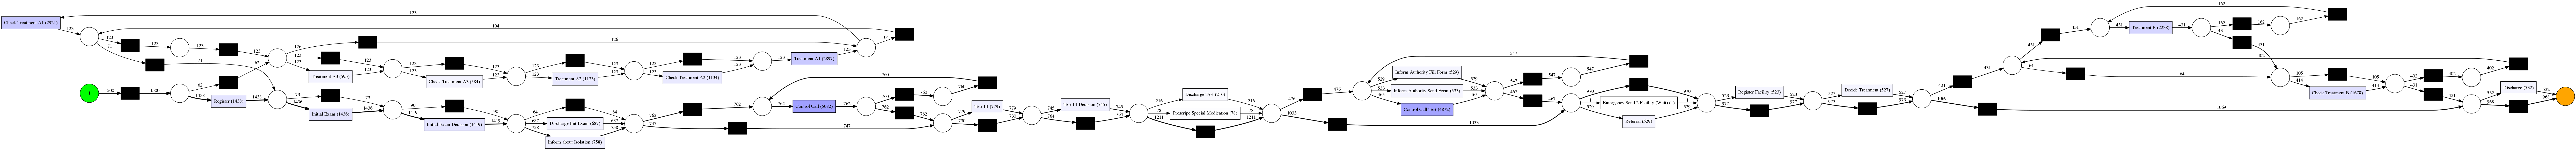

In [49]:
parameters = {"format":"png"}
gviz = pn_vis_factory.apply(dfg_net, im, fm, parameters=param_keys, variant="frequency", log=new_log)
file = "inductive_frequency.png"
dir_save=os.path.join(path_save_base,file)
pn_vis_factory.save(gviz,dir_save)
pn_vis_factory.view(gviz)

We did here a petri net with performance model (derived from the filtred DFG petri net)

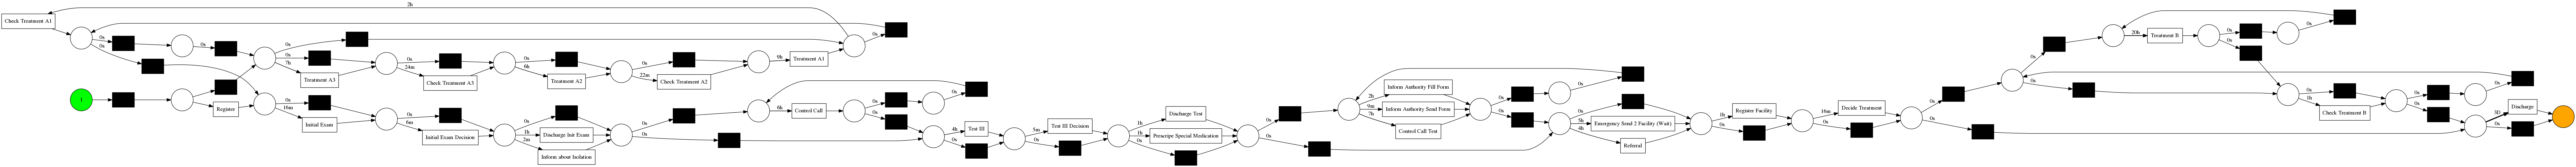

In [50]:
parameters = {"format":"png"}
#parameters_viz = {pn_vis_factory.Versions.PERFORMANCE.value.Parameters.AGGREGATION_MEASURE: "mean", pn_vis_factory.Versions.PERFORMANCE.value.Parameters.FORMAT: "svg"}
gviz = pn_vis_factory.apply(dfg_net, im, fm, parameters=param_keys, variant="performance", log=new_log)
file = "inductive_performance.png"
dir_save=os.path.join(path_save_base,file)
pn_vis_factory.save(gviz,dir_save)
pn_vis_factory.view(gviz)

### get a list of all activities in the log 

In [51]:
activities = log_attributes_filter.get_attribute_values(new_log, "concept:name")

In [52]:
dict_activity_pre_waiting_time =dict()
for activity in activities.keys():
    #print("Time Passed by each activity before performing activity :" + str(activity))
    pt_t =  log_passed_time.apply(new_log, activity, variant="pre")
    #print(pt_t)
    dict_activity_pre_waiting_time[activity]= pt_t

In [53]:
gviz = dfg_vis_factory.apply(dfg_filtered, log=new_log, variant="frequency")
#dfg_vis_factory.view(gviz)

In [54]:
gviz = dfg_vis_factory.apply(dfg_filtered, log=new_log, variant="performance")
#dfg_vis_factory.view(gviz)

In [55]:
variants = variants_filter.get_variants(new_log)
variants_count = case_statistics.get_variant_statistics(new_log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)
print(variants_count)
sum_so_far = 0

counter_unk=10
for dict_variant in variants_count:
    if counter_unk >0:
        sum_so_far+=dict_variant['count']
    counter_unk-=1
    
mean_variants_count = sum_so_far/len(variants_count)


[{'variant': 'Register,Initial Exam,Initial Exam Decision,Discharge Init Exam', 'count': 600}, {'variant': 'Register,Initial Exam,Initial Exam Decision,Inform about Isolation,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Test III,Test III Decision,Discharge Test', 'count': 41}, {'variant': 'Register,Initial Exam,Initial Exam Decision,Inform about Isolation,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Test III,Test III Decision,Discharge Test', 'count': 30}, {'variant': 'Register,Initial Exam,Discharge Init Exam', 'count': 30}, {'variant': 'Register,Initial Exam,Initial Exam Decision', 'count': 29}, {'variant': 'Initial Exam,Initial Exam Decision,Discharge Init Exam', 'count': 28}, {'variant': 'Register,Initial Exam,Initial Exam Decision,Inform about Isolation,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Test III,Test III Decision,Discharge Test', 'cou

In [56]:
mean_variants_count

1.4501718213058419

In [57]:
sum_so_far

844

In [58]:
len(variants)

582

Here we investgates the variants which have more than 15 cases, in order to further investigate if there  might be a delay  caused by the most frequent variants. The delay was computed using the lead_time per case, and getting the average per varaint.

In [59]:
high_variants =dict()
for variant, list_cases in variants.items():
    if len(list_cases) > 15:
        high_variants[variant] = list_cases

In [60]:
variant_cases_id = dict()
for key, value in high_variants.items():
    variant_cases_id[key]=[]
    for patient in value:
        id_pat = patient
        variant_cases_id[key].append(id_pat[0]['Patient'])

Obtaining the cases_ids for per variants in order to be able to compare it with the variants which have more than 15 cases.  

In [61]:
All_variant_cases_id = dict()
for key, value in variants.items():
    All_variant_cases_id[key]=[]
    for patient in value:
        id_pat = patient
        All_variant_cases_id[key].append(id_pat[0]['Patient'])

- Computing how much time is spend by each activity before firing a certain activity:

we will compute this for activities in the log, in order to be able to analyze which activity was the reason for longest time waiting for the execution to finish

### Lead Time which is the total time taken per trace 

#### cluster the log per case_id then compute the (inital_activity_start_time - end_activity_end_time)



In [62]:
Lead_time_per_patient = dict()

for  trace in new_log:
    patient_id = "patient_id " + str(trace[0]['Patient'])
    start_time = trace[0]['start_timestamp']
    end = len(trace)
    end_timeStamp = trace[end-1]['time:timestamp']
    Lead_time_per_patient[patient_id] = end_timeStamp - start_time

In [63]:
lead_time_pd = {'patient_id':[],
               'lead_time':[]}
for key , value in Lead_time_per_patient.items():
    lead_time_pd['patient_id'].append(key)
    lead_time_pd['lead_time'].append(value)

#lead_time_pd
pd_leadTime = pd.DataFrame(lead_time_pd)

In [64]:
pd_leadTime.to_csv('pd_leadTime.csv')

In [65]:
Lead_time_per_patient["min"] = pd_leadTime['lead_time'].min()
Lead_time_per_patient["max"] = pd_leadTime['lead_time'].max()
Lead_time_per_patient["mean"] = pd_leadTime['lead_time'].mean()

In [66]:
Lead_time_per_patient["max"]

Timedelta('21 days 22:46:08')

In [67]:
Lead_time_per_patient["mean"]

Timedelta('4 days 17:34:26.952000')

In [68]:
Lead_time_per_patient["min"]

Timedelta('0 days 00:11:47')

Obtaining the cases which have lead_time more than the mean lead_time as they are considered as the main reason for a total delay in time performance.  

In [69]:
cases_more_than_mean_lead_time=pd_leadTime[pd_leadTime['lead_time']>=Lead_time_per_patient["mean"]]

In [70]:
cases_more_than_mean_lead_time

patient_id        lead_time
0        patient_id 1  5 days 05:04:55
1        patient_id 2 11 days 03:16:07
2        patient_id 3  5 days 05:20:17
4        patient_id 5  5 days 06:12:31
7        patient_id 8  5 days 06:36:15
12      patient_id 13  5 days 07:00:34
13      patient_id 14  5 days 06:59:43
20      patient_id 21  5 days 19:57:02
23      patient_id 24  5 days 19:10:41
25      patient_id 26  7 days 23:30:06
30      patient_id 31  8 days 22:29:23
32      patient_id 33  5 days 23:28:12
34      patient_id 35  5 days 23:30:59
36      patient_id 37  6 days 16:37:57
37      patient_id 38  6 days 20:13:58
40      patient_id 41  6 days 20:43:19
42      patient_id 43  6 days 06:16:23
45      patient_id 46  8 days 06:06:23
47      patient_id 48  6 days 06:40:17
48      patient_id 49  6 days 07:33:49
50      patient_id 51  6 days 22:09:21
51      patient_id 52  6 days 07:30:58
56      patient_id 57  6 days 20:47:15
57      patient_id 58  8 days 07:16:28
58      patient_id 59  6 days 20:21:43
60      patient_id 61 12 days 04:05:33
61      patient_id 62  9 days 21:32:57
62      patient_id 63  5 days 23:58:35
65      patient_id 66  9 days 23:47:56
72      patient_id 73  9 days 00:05:08
...               ...              ...
1416  patient_id 1417 15 days 16:23:58
1417  patient_id 1418 16 days 18:10:54
1419  patient_id 1420 13 days 19:30:20
1420  patient_id 1421 18 days 20:27:04
1423  patient_id 1424 13 days 06:42:16
1427  patient_id 1428 18 days 04:18:21
1428  patient_id 1429 13 days 05:49:38
1431  patient_id 1432 16 days 04:03:50
1432  patient_id 1433 18 days 05:40:00
1434  patient_id 1435 13 days 06:59:27
1437  patient_id 1438 14 days 05:47:24
1439  patient_id 1440 13 days 19:59:11
1441  patient_id 1442 13 days 23:12:49
1450  patient_id 1451 16 days 21:02:08
1451  patient_id 1452 17 days 01:47:10
1452  patient_id 1453 16 days 01:47:58
1453  patient_id 1454 14 days 02:44:59
1454  patient_id 1455 19 days 17:08:46
1455  patient_id 1456 14 days 15:24:59
1458  patient_id 1459 13 days 23:54:30
1459  patient_id 1460 19 days 01:25:28
1473  patient_id 1474 13 days 23:38:36
1474  patient_id 1475 13 days 23:37:15
1478  patient_id 1479 13 days 22:22:56
1481  patient_id 1482 13 days 23:17:33
1483  patient_id 1484 16 days 00:08:40
1490  patient_id 1491 13 days 07:26:39
1491  patient_id 1492 13 days 07:01:36
1496  patient_id 1497 12 days 05:58:02
1497  patient_id 1498 13 days 08:52:14

[555 rows x 2 columns]

Computing  the percentage of the cases which took more than the average lead_time in order to know the proportion of those cases,  and if they have a great influence or not

In [71]:
r, c = pd_leadTime.shape

In [72]:
(len(cases_more_than_mean_lead_time)/r)*100

37.0

### Further analysis on the computed variants and lead_time

In the following we computed the average lead time taken by the variants which occured more than 15 times. From the computed average we can concluded that those variants might not be contributing that much in a delay as the maximum mean time take by any of those cases which have a trace with the respective variant is 2 day and 6hrs  

In [76]:
import datetime
variant_Lead_time = dict() 
for variant, pat_list in variant_cases_id.items():
    variant_Lead_time[variant]=[]
    sum_so_far = datetime.timedelta(hours=0)
    count_pat = len(pat_list)
    
    for id_pat in pat_list: 
        key = "patient_id "+ str(id_pat) 
        lead_time = Lead_time_per_patient[key]
        sum_so_far+=lead_time
        
    variant_Lead_time[variant].append(sum_so_far/count_pat)

In the following part we computed the variants which have the cases_id exceeding the average lead time.
- Results: none of the variants which have frequency of cases more than 15, have those cases which have a lead_time more than the average lead_time.

In [77]:
dict_variant_high_freq=dict()
for variant,  pat_list in variant_cases_id.items():
    dict_variant_high_freq[variant]=0
    for pat_id in pat_list:
        key = "patient_id "+ str(pat_id)
        #print(key)
        #print(cases_more_than_mean_lead_time.loc[cases_more_than_mean_lead_time['patient_id']== key])
        if len(cases_more_than_mean_lead_time.loc[cases_more_than_mean_lead_time['patient_id']== key]) > 0:
            dict_variant_high_freq[variant]+=1
            


In [78]:
dict_variant_high_freq

{'Register,Initial Exam Decision,Discharge Init Exam': 0,
 'Register,Initial Exam,Initial Exam Decision,Discharge Init Exam': 0,
 'Register,Initial Exam,Initial Exam Decision,Inform about Isolation,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Test III,Test III Decision,Discharge Test': 0,
 'Register,Initial Exam,Initial Exam Decision,Inform about Isolation,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Test III,Test III Decision,Discharge Test': 0,
 'Register,Initial Exam,Discharge Init Exam': 0,
 'Register,Initial Exam,Initial Exam Decision,Inform about Isolation,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Test III,Test III Decision,Discharge Test': 0,
 'Initial Exam,Initial Exam Decision,Discharge Init Exam': 0,
 'Register,Initial Exam,Initial Exam Decision': 0,
 'Register,Initial Exam,Initial Exam Decision,Inform about Isolation,Control Call,Contro

Th following is the avergae time taken by each vraiant for those variants which a frequency more than 15 cases

In [79]:
variant_Lead_time

{'Register,Initial Exam Decision,Discharge Init Exam': [Timedelta('0 days 00:54:31.818181')],
 'Register,Initial Exam,Initial Exam Decision,Discharge Init Exam': [Timedelta('0 days 01:49:09.986666')],
 'Register,Initial Exam,Initial Exam Decision,Inform about Isolation,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Test III,Test III Decision,Discharge Test': [Timedelta('2 days 04:33:29.115384')],
 'Register,Initial Exam,Initial Exam Decision,Inform about Isolation,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Test III,Test III Decision,Discharge Test': [Timedelta('2 days 03:39:28.487804')],
 'Register,Initial Exam,Discharge Init Exam': [Timedelta('0 days 02:23:21.100000')],
 'Register,Initial Exam,Initial Exam Decision,Inform about Isolation,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Test III,Test III Decision,Discharge Test': [Timedelta('2 days 06:34

In the following we compute the variants which have those cases that exceed the average leadt_time as those paths are required for further analysis of the activtites to see if they are responsable for the delay 

In [80]:
dict_more_than_avg_variants =dict()
for variant,  pat_list in All_variant_cases_id.items():
    dict_more_than_avg_variants[variant]=0
    for pat_id in pat_list:
        key = "patient_id "+ str(pat_id)
        #print(key)
        #print(cases_more_than_mean_lead_time.loc[cases_more_than_mean_lead_time['patient_id']== key])
        if len(cases_more_than_mean_lead_time.loc[cases_more_than_mean_lead_time['patient_id']== key]) > 0:
            dict_more_than_avg_variants[variant]+=1
    if dict_more_than_avg_variants[variant]==0:
        del dict_more_than_avg_variants[variant]

In order to further analyze those variants which are contributing to a time delay we first checked if they were sick or not and we found out that they all except for one variant recieved a treatment. But the remaining variant that did not recieve a treatment was quarentined after test results and sent to the Emergency, which indicates that he was a critical case. Thus, these variants are about sick patients.

In [81]:
counter_sick=0
for key, value in dict_more_than_avg_variants.items():
    #print(type(key))
    #print(key)
    if 'Treatment'in key:
        counter_sick+=1
    else:
        print("Variant which did not receive a treatment :")
        print(key)
        print("\n")

print("Totalnumber of variants which were sick and received treatment")
print(counter_sick)
        

Variant which did not receive a treatment :
Register,Initial Exam,Initial Exam Decision,Inform about Isolation,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Test III,Test III Decision,Inform Authority Fill Form,Inform Authority Send Form,Control Call Test,Control Call Test,Control Call Test,Control Call Test,Control Call Test,Control Call Test,Control Call Test,Control Call Test,Control Call Test,Control Call Test,Control Call Test,Emergency Send 2 Facility (Wait)


Totalnumber of variants which were sick and received treatment
521


Filter the log based on the varaints which have cases which exceed the avegrage lead_time (sick patients)

Create a new log which contains the variants with cases more than average time take 

In [82]:
from pm4py.algo.filtering.log.variants import variants_filter
filtered_log1 = variants_filter.apply(new_log, dict_more_than_avg_variants.keys())

In [498]:
#filtered_log1

In order to be able to detect the bottlenecks we will compute the average waiting time per activity, by subtracting the cycle time from the leadtime fro each activity. Those activities which have a high waiting time are considered to be main reason for bottlenecks thus we will check the assigned number of resources by checking the number of people working in the department responsible for those activites. We also take in consideration the frequencies.

In [83]:
from pm4py.objects.log.util import interval_lifecycle
enriched_log = interval_lifecycle.assign_lead_cycle_time(filtered_log1)

In [84]:
activity_wates_time_avg =dict()
for entry in enriched_log:
    for g in entry:
        focused_activity=g['Activity']
        if focused_activity not in activity_wates_time_avg.keys():
            activity_wates_time_avg[focused_activity]={'freq':0,'wates_time_total':0,'mean':0}
        activity_wates_time_avg[focused_activity]['freq']+=1
        #print(g['@@approx_bh_overall_wasted_time'])
        activity_wates_time_avg[focused_activity]['wates_time_total']+=g['@@approx_bh_overall_wasted_time']
        #print(g)

In [85]:
for key , _ in activity_wates_time_avg.items():
    activity_wates_time_avg[key]['mean']=activity_wates_time_avg[key]['wates_time_total']/activity_wates_time_avg[key]['freq'] 

In [86]:
sort_orders = sorted(activity_wates_time_avg.items(), key=lambda x: x[1]['mean'], reverse=True)

In [87]:
sort_orders

[('Discharge',
  {'freq': 532, 'wates_time_total': 156466140, 'mean': 294109.28571428574}),
 ('Treatment A1',
  {'freq': 2897, 'wates_time_total': 719687760, 'mean': 248425.18467380048}),
 ('Check Treatment A1',
  {'freq': 2921, 'wates_time_total': 724570020, 'mean': 248055.46730571723}),
 ('Treatment A2',
  {'freq': 1133, 'wates_time_total': 277934820, 'mean': 245308.75551632833}),
 ('Check Treatment A2',
  {'freq': 1134, 'wates_time_total': 277653780, 'mean': 244844.60317460317}),
 ('Check Treatment A3',
  {'freq': 584, 'wates_time_total': 139139220, 'mean': 238252.0890410959}),
 ('Treatment A3',
  {'freq': 595, 'wates_time_total': 141305340, 'mean': 237487.96638655462}),
 ('Emergency Send 2 Facility (Wait)',
  {'freq': 1, 'wates_time_total': 211620, 'mean': 211620.0}),
 ('Treatment B',
  {'freq': 2238, 'wates_time_total': 423450960, 'mean': 189209.54423592493}),
 ('Check Treatment B',
  {'freq': 1678, 'wates_time_total': 310181580, 'mean': 184851.9547079857}),
 ('Register Facility',

Create aperformance graph bases on those cases

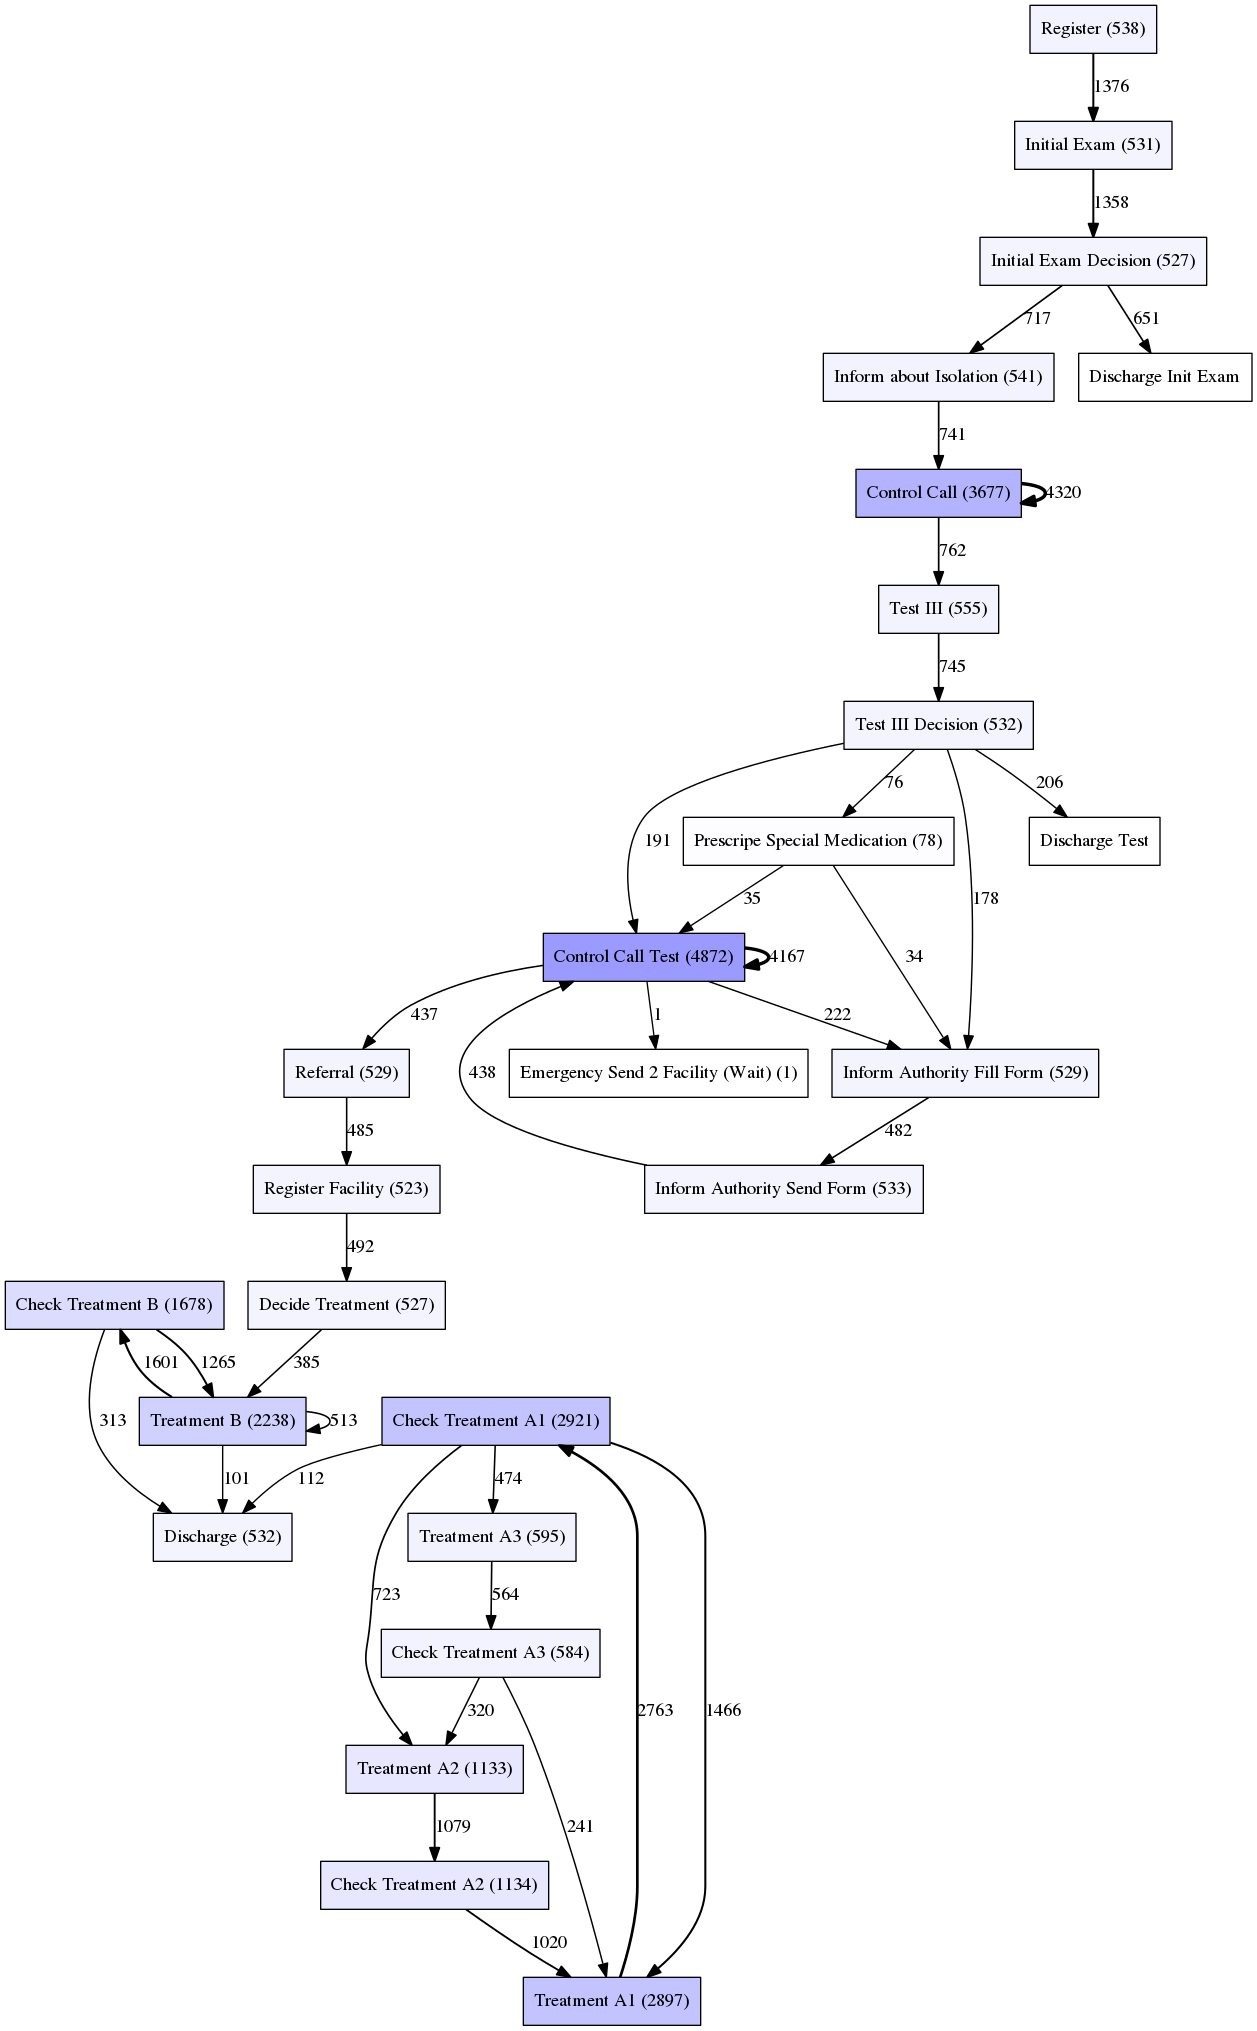

In [88]:
gviz = dfg_vis_factory.apply(dfg_filtered, log=filtered_log1, variant="frequency")
dfg_vis_factory.view(gviz)

# Q4. Decision Points

In the following sections, we intend to figure out which factors influence the decision making during the process. 

## a)    
We start by analyzing the attributes already given log by the log. However we first filter noise, by removing incomplete traces and the rarely performed activity _Emergency Send 2 Facility (Wait)_.

In [98]:
new_log = derive_and_lift_trace_attributes_from_event_attributes(log)

In [99]:
filter_log = attributes_filter.apply(new_log, ["Emergency Send 2 Facility (Wait)"], parameters={constants.PARAMETER_CONSTANT_ATTRIBUTE_KEY: "concept:name", "positive": False})
end_activities = end_activities_filter.get_end_activities(filter_log)
filtered_log = end_activities_filter.apply(log, ["Discharge", "Discharge Test", "Discharge Init Exam"])

Here we decide on the the prediction variables: _Insurance_ and _Age_ for the decision tree, and define _concept:name_ as the outcome variable.

In [100]:
str_trace_attributes = ['Insurance']
str_event_attributes = []
num_trace_attributes = ['Age']
num_event_attributes = []

data, feature_names = get_log_representation.get_representation(filtered_log, str_trace_attributes, str_event_attributes,num_trace_attributes, num_event_attributes)
target, classes = get_class_representation.get_class_representation_by_str_ev_attr_value_value(filtered_log, "concept:name")

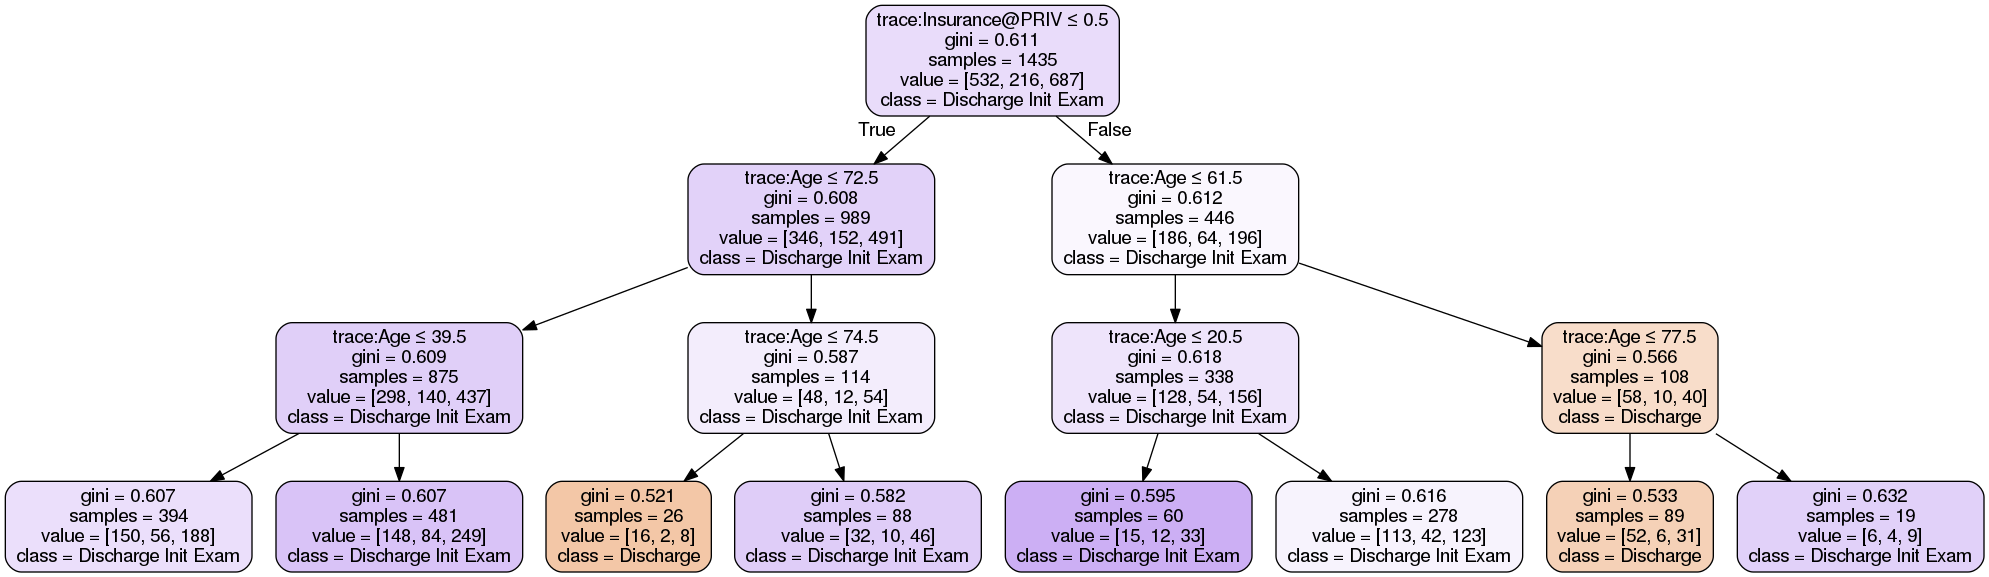

In [104]:
clf = tree.DecisionTreeClassifier(max_depth=3)

clf.fit(data, target)

gviz = dt_vis_factory.apply(clf, feature_names, classes, parameters={'format': "svg"})
dt_vis_factory.save(gviz, 'figures/decision_tree_a.svg')
gviz = dt_vis_factory.apply(clf, feature_names, classes)
dt_vis_factory.view(gviz)

## b)

In order to take bottlenecks, such as the number of patients into account, we start with deriving facilities.

### 1. Deriving Facilities

First, we derive the mapping between resources and activities, by calculating the similarity between the roles detected by the pm4py API and the roles discovered from the _joint assignment network_. 

In [105]:
def derive_resource_facility_mapping(role_groups, sn_groups, similarity_threshold=0.5):
    _map = []
            
    for fac in sn_groups:
        sn_group = sn_groups[fac]
        facility = []
        activities = []
        for role_group in role_groups:
            sim = jaccard_similarity(sn_group, role_group[1]) 
            if sim >= similarity_threshold:
                activities.extend(role_group[0])
        facility = [fac, activities, sn_group]
        _map.append(facility)
                
    return _map

The results show, that all discovered facilities don't have any activities in common (due to threshold). There is a total of 7 facilities, one of which includes the infrequent activity _Emergency Send 2 Facility (Wait)_ and can be ignored if we want to consider frequent traces.

In [106]:
role_groups = groups

sn_groups = {
    'Administration': group1 + group2 + group8,
    'Treatment Fac. B': group3,
    'Treatment Fac. C': group4,
    'Treatment Fac. D': group5,
    'Emergency': group6,
    'Inspection': group7
}

facility_mapping = derive_resource_facility_mapping(role_groups, sn_groups, similarity_threshold=0.01)

In [107]:
for facility in facility_mapping:
    print('\033[1m', facility[0], '\033[0m')
    print('\033[1m', facility[1], '\033[0m', '\n')
    print(facility[2])
    print("__________________________________________________________________________________________\n")

 Administration 
 ['Discharge Init Exam', 'Discharge Test', 'Register', 'Inform Authority Fill Form', 'Inform Authority Send Form', 'Inform about Isolation', 'Initial Exam', 'Test III', 'Initial Exam Decision', 'Test III Decision', 'Prescripe Special Medication', 'Referral']  

['Amalia', 'Ava', 'Anna', 'Alina', 'Amelie', 'Adrian', 'Alexander']
__________________________________________________________________________________________

 Treatment Fac. B 
 ['Check Treatment A1', 'Check Treatment A2', 'Check Treatment A3', 'Check Treatment B', 'Decide Treatment', 'Discharge', 'Treatment A1', 'Treatment A2', 'Treatment A3', 'Treatment B', 'Register Facility']  

['Benedikt', 'Bianca', 'Birgit', 'Babatunde', 'Barbara', 'Ben', 'Benjamin', 'Babelisk', 'Bruno', 'Babaoia', 'Babet', 'Bernhard', 'Brigitte', 'Bettina', 'Baal', 'Bella', 'Bente', 'Babak']
__________________________________________________________________________________________

 Treatment Fac. C 
 ['Check Treatment A1', 'Check Trea

### 2. Assigning estimation of number of patients to each event

Here we implement a function, in which we calculate the average number of patients in each facilitiy and then assign them to each event corresponding to one of the facilities discovered above.

In [111]:
def assign_patient_number_estimate(log_old, facility_mapping):
    log = copy.deepcopy(log_old)
    dates = set()
    for trace in log:
        for event in trace:
            date = str(datetime.strptime(str(event['start_timestamp']), '%Y-%m-%d %H:%M:%S'))
            dates.add(date.split()[0])
            for fac in facility_mapping:
                resources = event['org:resource'].split(',')
                bools = [i in fac[2] for i in resources]
                if False not in bools:
                    event['Facility'] = fac[0]
    
    dates = list(dates)
    freq = dict()
    
    for trace in log: 
        considered_day = []
        for event in trace:        
            date_string = str(datetime.strptime(str(event['start_timestamp']), '%Y-%m-%d %H:%M:%S'))
            date = date_string.split()[0]
            idx_date = dates.index(date)
            
            if 'Facility' in event and date not in considered_day:
                if event['Facility'] not in freq:
                    freq[event['Facility']] = [0]*len(dates)
                            
                freq[event['Facility']][idx_date] += 1
                considered_day.append(date)
                    
    
    for trace in log:
        for event in trace:
            if 'Facility' in event:
                estimates = freq[event['Facility']]
                avg = math.ceil(sum(estimates) / len(estimates))
                event['num_patients'] = avg

    return log, freq

In [112]:
log_new, freq = assign_patient_number_estimate(filtered_log, facility_mapping)

The following shows the average number of patients per facility:

In [113]:
for fac in freq:
    avg = math.ceil(sum(freq[fac]) / len(freq[fac]))
    print(fac,':', '~', avg)

Administration : ~ 28
Treatment Fac. B : ~ 20
Treatment Fac. D : ~ 19
Inspection : ~ 51
Treatment Fac. C : ~ 19


### 3. Creating decision tree with new attribute 

Now we apply the previously calculated log to a decision tree and add the calculated attribute _num__patients_.

In [121]:
str_trace_attributes = ['Insurance']
str_event_attributes = []
num_trace_attributes = ['Age']
num_event_attributes = ['num_patients']

data, feature_names = get_log_representation.get_representation(log_new, str_trace_attributes, str_event_attributes,num_trace_attributes, num_event_attributes)

target, classes = get_class_representation.get_class_representation_by_str_ev_attr_value_value(log_new, 'concept:name')

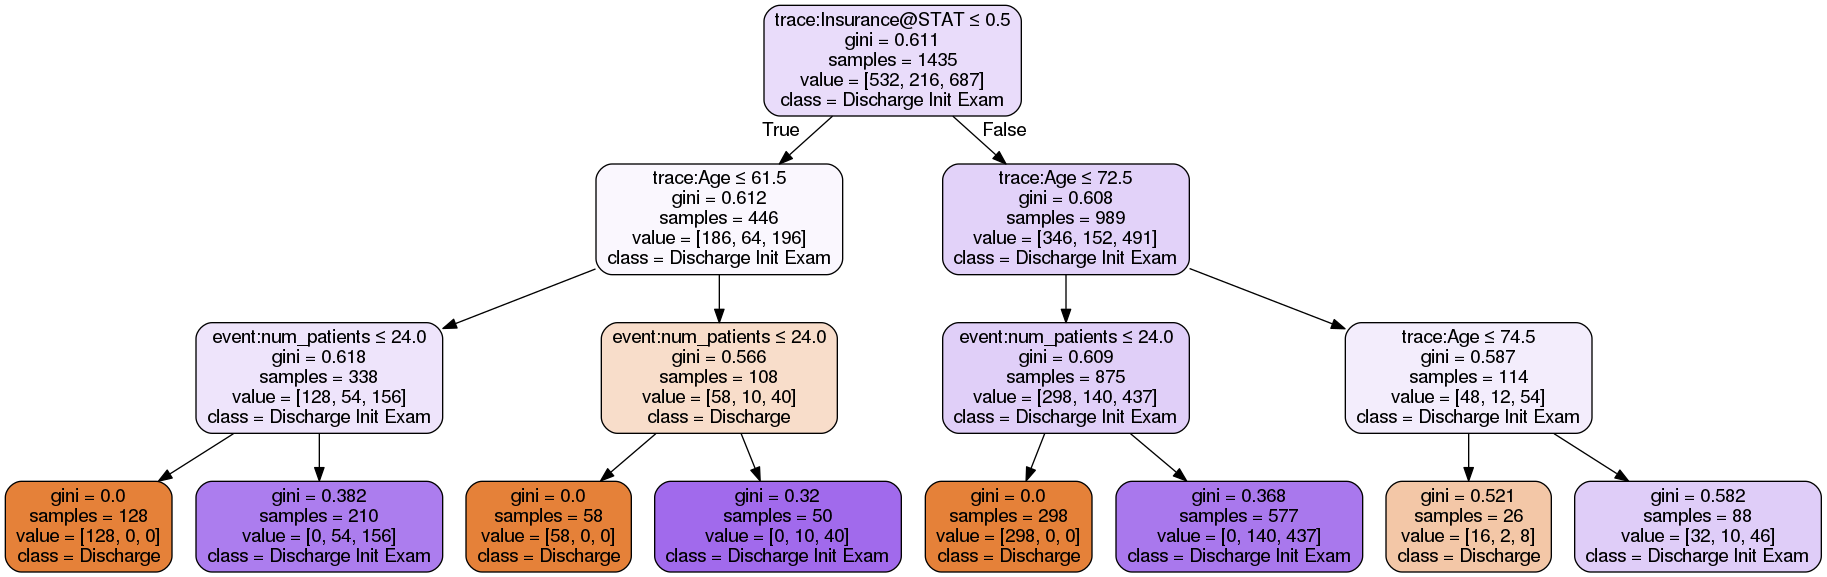

In [123]:
clf = tree.DecisionTreeClassifier(max_depth=3, max_features=1, random_state=0)

clf.fit(data, target)

gviz = dt_vis_factory.apply(clf, feature_names, classes, parameters={'format': "svg"})
dt_vis_factory.save(gviz, 'figures/decision_tree_b.svg')
gviz = dt_vis_factory.apply(clf, feature_names, classes)
dt_vis_factory.view(gviz)